# irp-dbk24 - "Optimising Demand Response Strategies for Carbon-Intelligent Electricity Use"

# STEP 6 Analysis

### Importing Libraries

In [161]:
# ─────────────────────────────────────────────────────────────────────────────
# Notebook/Display Tools
# ─────────────────────────────────────────────────────────────────────────────
from IPython.display import display, HTML
%matplotlib inline

# ────────────────────────────────────────────────────────────────────────────
# Data Manipulation & Analysis
# ─────────────────────────────────────────────────────────────────────────────
import pandas as pd
import polars as pl
import numpy as np
from zoneinfo import ZoneInfo

# ─────────────────────────────────────────────────────────────────────────────
# Geospatial Data Handling
# ─────────────────────────────────────────────────────────────────────────────
import geopandas as gpd
from shapely.geometry import Point, Polygon
from shapely.wkb import loads
from pyproj import Proj, transform

# ─────────────────────────────────────────────────────────────────────────────
# Visualization
# ─────────────────────────────────────────────────────────────────────────────
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from matplotlib.dates import AutoDateLocator, ConciseDateFormatter
import seaborn as sns
import folium
from webdriver_manager.chrome import ChromeDriverManager
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from PIL import Image

# ─────────────────────────────────────────────────────────────────────────────
# System / Miscellaneous
# ─────────────────────────────────────────────────────────────────────────────
import os
import calendar
import binascii
import re
from functools import reduce
from typing import List, Tuple, Optional, Dict, Literal, Any,Iterable, Sequence, Union
from datetime import datetime, timedelta
from pathlib import Path
from matplotlib.ticker import MultipleLocator


### Directories, Filenames, Filepaths

In [2]:
# Base directory for data
base_data_directory = "data"
 # Directory for hitachi data
hitachi_data_directory = os.path.join(base_data_directory, "hitachi_copy")
optimisation_development_directory = os.path.join(base_data_directory, "optimisation_development")
optimisation_development_processing = os.path.join(optimisation_development_directory, "processing_files")


In [3]:
# Filenames
emission_factors_filename = "marginal_and_average_emissions_2021-01-01_to_2025-05-31"
emission_factors_filepath = os.path.join(optimisation_development_processing, f"{emission_factors_filename}.parquet")

### Loading Data

In [4]:
emissions_factors_pldf = pl.read_parquet(emission_factors_filepath)

#### Initial Look at Data

In [5]:
print("-"*120)
print("Sample Rows of [emissions_factors_pldf] : \n"+ "-"*120)
display(emissions_factors_pldf.sample(8))

------------------------------------------------------------------------------------------------------------------------
Sample Rows of [emissions_factors_pldf] : 
------------------------------------------------------------------------------------------------------------------------


average_emissions_grams_co2_per_kWh,timestamp,city,land_longitude,land_latitude,demand_met_kWh,quantile_marginal_emissions_grams_co2_per_kWh,pg_marginal_emissions_grams_co2_per_kWh,pg_marginal_emissions_grams_co2_per_kWh_calibrated,National MW Shift,Pearson R Score,Spearman Score,Confidence Level
f64,"datetime[μs, Asia/Kolkata]",cat,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
714.225878,2023-02-22 16:00:00 IST,"""delhi""",77.14,28.8,9.7987e7,677.671717,865.142957,759.894736,2792.625,0.549384,0.583061,"""medium"""
721.536844,2023-08-26 02:30:00 IST,"""delhi""",77.34,28.4,9.7387e7,561.078442,740.87165,483.254379,1850.458333,0.517684,0.559181,"""medium"""
602.13031,2022-09-23 17:00:00 IST,"""mumbai""",72.97,19.3,8.4728e7,802.339659,884.63477,803.285462,4865.583333,0.568243,0.60797,"""medium"""
788.216318,2022-01-14 19:30:00 IST,"""mumbai""",72.87,19.3,7.853125e7,891.415059,854.574575,736.368462,3201.958333,0.557175,0.588787,"""medium"""
782.512818,2024-10-19 18:00:00 IST,"""delhi""",77.04,28.5,9.7758e7,718.176782,706.737229,407.267745,8403.5,0.581367,0.630714,"""medium"""
678.318147,2024-09-17 08:00:00 IST,"""delhi""",77.24,28.7,9.5365e7,651.361545,845.030742,715.122934,7084.458333,0.581367,0.630714,"""medium"""
663.509054,2024-07-09 16:30:00 IST,"""delhi""",76.94,28.7,1.0468e8,654.962049,843.285905,711.238754,1126.416667,0.456064,0.522479,"""medium"""
690.344908,2022-11-17 14:30:00 IST,"""delhi""",77.14,28.5,8.4212375e7,803.036378,935.91148,917.432546,3445.458333,0.558795,0.591595,"""medium"""


#### Checking scope of emission factors:

In [6]:
#
ef_cols = [
    "average_emissions_grams_co2_per_kWh",
    "quantile_marginal_emissions_grams_co2_per_kWh",
    "pg_marginal_emissions_grams_co2_per_kWh",
    "pg_marginal_emissions_grams_co2_per_kWh_calibrated",
]
tol = 1e-6  # tighten/loosen as needed

# Compute per-timestamp min/max for each EF and flag violations
minmax = (
    emissions_factors_pldf
    .group_by("timestamp")
    .agg(
        *[pl.col(c).min().alias(f"{c}__min") for c in ef_cols],
        *[pl.col(c).max().alias(f"{c}__max") for c in ef_cols],
        *[pl.col(c).null_count().alias(f"{c}__nulls") for c in ef_cols],
        pl.len().alias("rows_per_ts")
    )
)

In [7]:
# Add range columns and long-ify for an easy summary
with_ranges = minmax.with_columns(
    *[
        (pl.col(f"{c}__max") - pl.col(f"{c}__min")).abs().alias(f"{c}__range")
        for c in ef_cols
    ]
)

# --- Long form + violation flag (FIXED alias placement) ---
violations_long = (
    with_ranges
    .select(
        "timestamp",
        *[pl.col(f"{c}__range").alias(c) for c in ef_cols]
    )
    .unpivot(index="timestamp", variable_name="ef", value_name="range")
    .with_columns(
        (pl.col("range") > tol).alias("violation")  # <-- alias on the expression
    )
)


In [8]:
# --- Summary of invariance ---
ef_invariance_summary = (
    violations_long
    .group_by("ef")
    .agg(
        pl.len().alias("timestamps_total"),
        pl.sum("violation").alias("timestamps_violating"),
        (pl.mean("violation")).alias("share_violating"),
        pl.max("range").alias("max_range")
    )
)
ef_invariance_summary

ef,timestamps_total,timestamps_violating,share_violating,max_range
str,u32,u32,f64,f64
"""pg_marginal_emissions_grams_co…",77376,0,0.0,1.6290e-8
"""pg_marginal_emissions_grams_co…",77376,0,0.0,3.6263e-8
"""quantile_marginal_emissions_gr…",77376,75736,0.978805,238.879044
"""average_emissions_grams_co2_pe…",77376,0,0.0,0.0


### Analysis

#### Helper Functions

In [9]:
# Convenience: to_pandas for plotting
def to_pd(df_pl: pl.DataFrame) -> pd.DataFrame:
    return df_pl.to_pandas()


In [10]:
def _ensure_cols_present(df: pl.DataFrame, ef_cols: Sequence[str]) -> List[str]:
    """Ensure that the specified columns are present in the DataFrame."""
    return [c for c in ef_cols if c in df.columns]

In [11]:
def _to_lazy(df: pl.DataFrame | pl.LazyFrame) -> pl.LazyFrame:
    """Convert a DataFrame to a LazyFrame."""
    return df.lazy() if isinstance(df, pl.DataFrame) else df


In [12]:
def _ensure_datetime_tz(
        df: pd.DataFrame,
        tz: str,
        timestamp_col = "timestamp"
        ) -> pd.DataFrame:
    """
    Ensure the timestamp column is datetime with the specified timezone.

    Parameters
    ----------
    df : pd.DataFrame
        The DataFrame to modify.
    tz : str
        The timezone to set.
    timestamp_col : str
        The name of the timestamp column.

    Returns
    -------
    pd.DataFrame
        The modified DataFrame with the correct timezone.
    """

    if not np.issubdtype(df[timestamp_col].dtype, np.datetime64):
        df[timestamp_col] = pd.to_datetime(df[timestamp_col], errors="coerce")
    # Localize if naive; otherwise convert to target tz
    if df[timestamp_col].dt.tz is None:
        df[timestamp_col] = df[timestamp_col].dt.tz_localize(tz)
    else:
        df[timestamp_col] = df[timestamp_col].dt.tz_convert(tz)
    return df


In [13]:
def _resolve_col(
        df: pl.DataFrame | pl.LazyFrame,
        *candidates: str
) -> str:
    """
    Given a Polars DataFrame or LazyFrame and a list of candidate column names,
    return the first column name that matches one of the candidates, or raise a KeyError.

    Parameters
    ----------
    df : pl.DataFrame | pl.LazyFrame
        The DataFrame or LazyFrame to search.
    *candidates : str
        The candidate column names to match.

    Returns
    -------
    str
        The first matching column name.
    """
    cols = df.columns if isinstance(df, pl.DataFrame) else df.collect_schema().names()
    for cand in candidates:
        if cand in cols:
            return cand
    norm = {re.sub(r'[^a-z0-9]+', '', c.lower()): c for c in cols}
    for cand in candidates:
        key = re.sub(r'[^a-z0-9]+', '', cand.lower())
        if key in norm:
            return norm[key]
    raise KeyError(f"None of {candidates} found. Columns: {cols}")


In [14]:
def nationalize_with_quantile_mean(
    df: pl.DataFrame | pl.LazyFrame,
    *,
    time_col: str = "timestamp",
    quantile_col: str = "quantile_marginal_emissions_grams_co2_per_kWh",
    weight_col: Optional[str] = None,          # e.g. "demand_met_kWh" for demand-weighted mean; None => simple mean
    drop_location_cols: Iterable[str] = ("city", "land_longitude", "land_latitude"),
    set_city_label: Optional[str] = "national", # None to skip adding a city label
    demand_col: Optional[str] = "demand_met_kWh",
    sum_demand: bool = True                    # if demand_col provided: True => sum to national; False => take first()
) -> pl.DataFrame | pl.LazyFrame:
    """
    Collapse to one row per timestamp by averaging the *quantile* emissions across locations,
    while keeping other columns (assumed invariant across locations) via .first().

    Works with either a Polars DataFrame or LazyFrame. If you pass a LazyFrame,
    remember to call .collect() on the result.

    Parameters
    ----------
    df : pl.DataFrame | pl.LazyFrame
        Source table with multiple locations per timestamp.
    time_col : str
        Timestamp column.
    quantile_col : str
        Column that is local (varies by location) and should be averaged across locations.
    weight_col : str | None
        Optional column name to use as weights for a demand-weighted mean of `quantile_col`.
    drop_location_cols : Iterable[str]
        Location columns to drop in the output.
    set_city_label : str | None
        If not None, add a constant "city" column with this label (e.g., "national").
    demand_col : str | None
        If provided, will be aggregated (sum or first) and kept in the output.
    sum_demand : bool
        If True, sum `demand_col` across locations; if False, take `first()`.

    Returns
    -------
    pl.DataFrame | pl.LazyFrame
        One row per timestamp, quantile averaged, other columns kept via first().
    """
    all_cols = df.columns

    # columns to exclude from "keep-first"
    exclude = {time_col, quantile_col, *drop_location_cols}
    if demand_col:
        exclude.add(demand_col)

    # everything else is treated as invariant and kept via first()
    keep_first_cols = [c for c in all_cols if c not in exclude]

    # quantile mean expression (weighted or unweighted)
    if weight_col:
        num = (pl.col(quantile_col) * pl.col(weight_col)).sum()
        den = pl.col(weight_col).sum()
        q_mean_expr = pl.when(den > 0).then((num / den)).otherwise(None).alias(quantile_col)
    else:
        q_mean_expr = pl.col(quantile_col).mean().alias(quantile_col)

    # demand aggregation expression (optional)
    demand_exprs = []
    if demand_col is not None and demand_col in all_cols:
        if sum_demand:
            demand_exprs.append(pl.col(demand_col).sum().alias(demand_col))
        else:
            demand_exprs.append(pl.col(demand_col).first().alias(demand_col))

    # keep-first expressions for assumed-invariant columns
    keep_exprs = [pl.col(c).first().alias(c) for c in keep_first_cols]

    out = (
        df.group_by(time_col)
          .agg([q_mean_expr, *demand_exprs, *keep_exprs])
          .drop([c for c in drop_location_cols if c in keep_first_cols])  # ensure location cols are gone
    )

    # Optionally add a single "city" label
    if set_city_label is not None:
        out = out.with_columns(pl.lit(set_city_label).alias("city"))

    # Reorder (timestamp first for convenience)
    out = out.select(
        [time_col, *(c for c in out.columns if c != time_col)]
    )
    return out


In [15]:
def yearly_means(
    df: pl.DataFrame | pl.LazyFrame,
    *,
    time_candidates=("timestamp","mestamp","time"),
    ef_cols: Sequence[str],
) -> pl.DataFrame:
    """
    Compute yearly means of the specified emission factor columns.

    Parameters
    ----------
    df : pl.DataFrame | pl.LazyFrame
        The input DataFrame or LazyFrame.
    time_candidates : tuple of str
        Column names to consider as time indicators.
    ef_cols : Sequence[str]
        The emission factor columns to aggregate.

    Returns
    -------
    pl.DataFrame
        A DataFrame with the yearly means of the specified columns.
    """
    TIME = _resolve_col(df, *time_candidates)
    lf = _to_lazy(df)
    agg_exprs = [pl.col(c).mean().alias(c) for c in ef_cols]
    out = (
        lf.with_columns(year = pl.col(TIME).dt.year())
          .group_by("year")
          .agg(agg_exprs)
          .sort("year")
          .collect()
    )
    return out


In [16]:
def monthly_means_by_year(
    df: pl.DataFrame | pl.LazyFrame,
    *,
    time_candidates=("timestamp","mestamp","time"),
    ef_cols: Sequence[str],
) -> pl.DataFrame:
    """
    Compute monthly means of the specified emission factor columns, grouped by year.

    Parameters
    ----------
    df : pl.DataFrame | pl.LazyFrame
        The input DataFrame or LazyFrame.
    time_candidates : tuple of str
        Column names to consider as time indicators.
    ef_cols : Sequence[str]
        The emission factor columns to aggregate.

    Returns
    -------
    pl.DataFrame
        A DataFrame with the monthly means of the specified columns.
    """
    TIME = _resolve_col(df, *time_candidates)
    lf = _to_lazy(df)
    agg_exprs = [pl.col(c).mean().alias(c) for c in ef_cols]
    out = (
        lf.with_columns(
            year = pl.col(TIME).dt.year(),
            month = pl.col(TIME).dt.month()
        )
        .group_by(["year","month"])
        .agg(agg_exprs)
        .sort(["year","month"])
        .collect()
    )
    return out


In [17]:
# ---------- weighted confidence aggregation ----------
def confidence_weighted_by(
        df: pl.DataFrame | pl.LazyFrame,
        *,
        period: str = "year",  # "year" | "month" | "hour"
        # columns to find
        time_candidates: Sequence[str] = ("timestamp","mestamp","time"),
        conf_candidates: Sequence[str] = ("Confidence Level","confidence_level","confidence"),
        weight_candidates: Sequence[str] = ("demand_met_kWh", "National MW Shift", "mw_shift"),
        # category handling
        categories: Sequence[str] = ("low","high"),  # include "medium" if you want
        # weighting behavior
        use_abs_weight: bool = False,  # set True when weighting by shift magnitudes
        return_share: bool = True,     # True=share of weight; False=total weight per category
        years: Optional[Union[int, Iterable[int], Tuple[int,int]]] = None,  # optional filter
        include_total: bool = True,
) -> pl.DataFrame:
    """
    Aggregate confidence categories using a weight (e.g., demand or shift).
    Returns one row per period value with columns for each category (share or total).

    Parameters:
    ----------
    df : pl.DataFrame | pl.LazyFrame
        The input DataFrame to aggregate.
    period : str
        The time period to aggregate by ("year", "month", or "hour").
    time_candidates : Sequence[str]
        Column names to search for the time information.
    conf_candidates : Sequence[str]
        Column names to search for the confidence level information.
    weight_candidates : Sequence[str]
        Column names to search for the weight information.
    categories : Sequence[str]
        The confidence categories to include in the aggregation.
    use_abs_weight : bool
        Whether to use absolute weight values (True) or not (False).
    return_share : bool
        Whether to return the share of weight (True) or the total weight per category (False).
    years : Optional[Union[int, Iterable[int], Tuple[int,int]]]
        Years to filter the data by (if any).
    include_total : bool
        Whether to include a total weight column in the output.

    Returns:
    -------
    pl.DataFrame
        The aggregated DataFrame with confidence categories as columns.

    """
    TIME = _resolve_col(df, *time_candidates)
    CONF = _resolve_col(df, *conf_candidates)
    WCOL = _resolve_col(df, *weight_candidates)

    # normalize year filter
    years_list = None
    if years is not None:
        if isinstance(years, int):
            years_list = [years]
        elif isinstance(years, tuple) and len(years) == 2:
            y0, y1 = sorted(map(int, years))
            years_list = list(range(y0, y1+1))
        else:
            years_list = sorted({int(y) for y in years})

    lf = _to_lazy(df).with_columns(
        _conf = pl.col(CONF).cast(pl.Utf8, strict=False).str.to_lowercase(),
        _w = (pl.col(WCOL).abs() if use_abs_weight else pl.col(WCOL)).alias("_w")
    )

    if years_list:
        lf = lf.filter(pl.col(TIME).dt.year().is_in(years_list))

    # choose period index
    if period == "year":
        lf = lf.with_columns(idx = pl.col(TIME).dt.year())
    elif period == "month":
        lf = lf.with_columns(idx = pl.col(TIME).dt.month())
    elif period == "hour":
        lf = lf.with_columns(idx = pl.col(TIME).dt.hour())
    else:
        raise ValueError("period must be 'year', 'month', or 'hour'")

    # per-category weighted totals
    agg_exprs = [
        pl.when(pl.col("_conf") == pl.lit(cat)).then(pl.col("_w")).otherwise(0.0).sum().alias(cat)
        for cat in categories
    ]
    if include_total:
        agg_exprs.append(pl.col("_w").sum().alias("total_weight"))

    out = (
        lf.group_by("idx")
          .agg(agg_exprs)
          .sort("idx")
          .rename({"idx": period})
          .collect()
    )

    if return_share:
        # divide by total_weight safely
        if "total_weight" not in out.columns:
            raise ValueError("include_total must be True when return_share=True.")
        for cat in categories:
            out = out.with_columns(
                pl.when(pl.col("total_weight") > 0)
                  .then(pl.col(cat) / pl.col("total_weight"))
                  .otherwise(None)
                  .alias(cat)
            )
    return out

In [18]:
# ---------- aggregation ----------
def confidence_counts(
        df: pl.DataFrame | pl.LazyFrame,
        *,
        period: str = "year",  # "year" | "month" | "hour"
        time_candidates: Sequence[str] = ("timestamp","mestamp","time"),
        conf_candidates: Sequence[str] = ("Confidence Level","confidence_level","confidence"),
        categories: Sequence[str] = ("low","high"),
        years: Optional[Union[int, Iterable[int], Tuple[int,int]]] = None,  # filter years
        include_total: bool = True,
) -> pl.DataFrame:
    """
    Count confidence categories by year/month/hour.

    Parameters:
    ----------
    df: pl.DataFrame | pl.LazyFrame
        The input DataFrame or LazyFrame.
    period: str
        The time period to aggregate by ("year", "month", or "hour").
    time_candidates: Sequence[str]
        Column names to use for the time dimension.
    conf_candidates: Sequence[str]
        Column names to use for the confidence dimension.
    categories: Sequence[str]
        Confidence categories to include in the output.
    years: Optional[Union[int, Iterable[int], Tuple[int,int]]]
        Years to filter the data by.
    include_total: bool
        Whether to include a total count across all categories.

    Returns:
    -------
    pl.DataFrame
        A DataFrame with the aggregated confidence counts.
    """
    TIME = _resolve_col(df, *time_candidates)
    CONF = _resolve_col(df, *conf_candidates)

    # normalize 'years' filter
    years_list = None
    if years is not None:
        if isinstance(years, int):
            years_list = [years]
        elif isinstance(years, tuple) and len(years) == 2:
            y0, y1 = sorted(map(int, years))
            years_list = list(range(y0, y1+1))
        else:
            years_list = sorted({int(y) for y in years})

    lf = _to_lazy(df).with_columns(
        _conf = pl.col(CONF).cast(pl.Utf8, strict=False).str.to_lowercase()
    )

    if years_list:
        lf = lf.filter(pl.col(TIME).dt.year().is_in(years_list))

    # choose the period column
    if period == "year":
        lf = lf.with_columns(idx = pl.col(TIME).dt.year())
    elif period == "month":
        lf = lf.with_columns(idx = pl.col(TIME).dt.month())
    elif period == "hour":
        lf = lf.with_columns(idx = pl.col(TIME).dt.hour())
    else:
        raise ValueError("period must be one of {'year','month','hour'}")

    # build per-category counters
    agg_exprs = [
        (pl.col("_conf") == pl.lit(cat)).sum().cast(pl.Int64).alias(cat)
        for cat in categories
    ]
    if include_total:
        agg_exprs.append(pl.len().alias("total"))

    out = (
        lf.group_by("idx")
          .agg(agg_exprs)
          .sort("idx")
          .rename({"idx": period})
          .collect()
    )
    return out

In [19]:
def confidence_counts_by_hour_per_year(
        df: pl.DataFrame | pl.LazyFrame,
        *,
        time_col_candidates=("timestamp","mestamp","time"),
        conf_col_candidates=("Confidence Level","confidence_level","confidence"),
        categories: Sequence[str] = ("low","medium"),
        years: Optional[Sequence[int]] = None
) -> pl.DataFrame:
    """
    Count confidence categories by hour of day, separately for each year.

    Parameters
    ----------
    df: pl.DataFrame | pl.LazyFrame
        The input DataFrame or LazyFrame containing the data.
    time_col_candidates: Sequence[str]
        A sequence of column names to consider as the time column.
    conf_col_candidates: Sequence[str]
        A sequence of column names to consider as the confidence column.
    categories: Sequence[str]
        A sequence of confidence categories to count.
    years: Optional[Sequence[int]]
        A sequence of years to filter the data by.

    Returns
    -------
    pl.DataFrame
        A DataFrame containing the counts of confidence categories by hour of day and year.

    """
    # resolve cols
    cols = df.columns if isinstance(df, pl.DataFrame) else df.collect_schema().names()
    TIME = next((c for c in time_col_candidates if c in cols), None)
    CONF = next((c for c in conf_col_candidates if c in cols), None)
    if TIME is None or CONF is None:
        raise KeyError(f"Missing time/conf columns. Got: {cols}")

    lf = (df.lazy() if isinstance(df, pl.DataFrame) else df).with_columns(
        year = pl.col(TIME).dt.year(),
        hour = pl.col(TIME).dt.hour(),
        _conf = pl.col(CONF).cast(pl.Utf8, strict=False).str.to_lowercase()
    )
    if years is not None:
        lf = lf.filter(pl.col("year").is_in(list(years)))

    agg_exprs = [(pl.col("_conf") == pl.lit(cat)).sum().cast(pl.Int64).alias(cat) for cat in categories]

    return (
        lf.group_by(["year","hour"])
          .agg(agg_exprs)
          .sort(["year","hour"])
          .collect()
    )

In [20]:
def calibration_deltas(
        df: pl.DataFrame | pl.LazyFrame,
        *,
        time_col="timestamp",
        pg="pg_marginal_emissions_grams_co2_per_kWh",
        pg_cal="pg_marginal_emissions_grams_co2_per_kWh_calibrated"
) -> pl.DataFrame:
    """
    Compute calibration deltas and ratios.

    Parameters
    ----------
    df : pl.DataFrame | pl.LazyFrame
        Input DataFrame containing the data to process.
    time_col : str
        Name of the column containing the timestamp.
    pg : str
        Name of the column containing the raw PG emissions.
    pg_cal : str
        Name of the column containing the calibrated PG emissions.

    Returns
    -------
    pl.DataFrame
        DataFrame containing the calibration deltas and ratios.
    """

    lf = df.lazy() if isinstance(df, pl.DataFrame) else df
    return (
        lf.select(
            pl.col(time_col),
            pl.col(pg),
            pl.col(pg_cal),
            (pl.col(pg_cal) - pl.col(pg)).alias("delta_cal"),
            (pl.col(pg_cal) / pl.col(pg)).alias("ratio_cal"),
            pl.col(time_col).dt.month().alias("month"),
            pl.col(time_col).dt.hour().alias("hour")
        )
        .collect()
    )

In [21]:
def mef_vs_aef_gap(
        df: pl.DataFrame | pl.LazyFrame,
        time_col="timestamp",
        mef="pg_marginal_emissions_grams_co2_per_kWh_calibrated",
        aef="average_emissions_grams_co2_per_kWh"
) -> pl.DataFrame:
    """
    Compute the gap between marginal and average emissions.

    Parameters
    ----------
    df: pl.DataFrame | pl.LazyFrame
        The input DataFrame or LazyFrame containing emission data.
    time_col: str
        The name of the column containing timestamp information.
    mef: str
        The name of the column containing marginal emissions data.
    aef: str
        The name of the column containing average emissions data.

    Returns
    -------
    pl.DataFrame
        A DataFrame containing the computed gaps and ratios.
    """
    lf = df.lazy() if isinstance(df, pl.DataFrame) else df
    return (
        lf.select(
            pl.col(time_col),
            (pl.col(mef) - pl.col(aef)).alias("delta_mef_aef"),
            (pl.col(mef) / pl.col(aef)).alias("ratio_mef_aef"),
            pl.col(time_col).dt.month().alias("month"),
            pl.col(time_col).dt.hour().alias("hour")
        ).collect()
    )


In [22]:
def crosscorr_pg_shift(
        df: pl.DataFrame | pl.LazyFrame,
        *,
        time_col="timestamp",
        pg_col="pg_marginal_emissions_grams_co2_per_kWh",
        shift_col="National MW Shift",
        freq="H",
        max_lag=6
) -> pd.DataFrame:
    """
    Compute cross-correlation between PG MEF and National MW Shift.

    Parameters
    ----------
    df : pl.DataFrame | pl.LazyFrame
        Input DataFrame containing the relevant time series data.
    time_col : str
        Name of the column containing the time information.
    pg_col : str
        Name of the column containing the PG MEF data.
    shift_col : str
        Name of the column containing the National MW Shift data.
    freq : str
        Frequency for resampling the time series data.
    max_lag : int
        Maximum lag (in hours) to consider for cross-correlation.

    Returns
    -------
    pd.DataFrame
        DataFrame containing the cross-correlation results.
    """
    lf = df.lazy() if isinstance(df, pl.DataFrame) else df
    tmp = lf.select([time_col, pg_col, shift_col]).collect().to_pandas()
    tmp = tmp.set_index(pd.to_datetime(tmp[time_col])).sort_index().resample(freq).mean()
    X = tmp[pg_col]; Y = tmp[shift_col]
    out = []
    for k in range(-max_lag, max_lag+1):
        if k < 0:
            corr = X.shift(-k).corr(Y)
        else:
            corr = X.corr(Y.shift(k))
        out.append({"lag_hours": k, "corr": corr})
    return pd.DataFrame(out)

In [23]:
def low_conf_demand_share_by_month_year(
        df: pl.DataFrame | pl.LazyFrame,
        *,
        time_col: str = "timestamp",
        conf_col: str = "Confidence Level",
        demand_col: str = "demand_met_kWh",
        low_label: str = "low",
) -> pl.DataFrame:
    """
    Share of total demand that occurred under LOW confidence, by month×year.

    Parameters:
    ----------
    df: pl.DataFrame | pl.LazyFrame
        The input DataFrame or LazyFrame containing the data.
    time_col: str
        The name of the column containing the timestamp.
    conf_col: str
        The name of the column containing the confidence level.
    demand_col: str
        The name of the column containing the demand met (in kWh).
    low_label: str
        The label used to identify low confidence levels.

    Returns:
    -------
    pl.DataFrame
        A DataFrame containing the share of low confidence demand by month and year.
    """
    lf = df.lazy() if isinstance(df, pl.DataFrame) else df
    out = (
        lf.with_columns(
              year = pl.col(time_col).dt.year(),
              month = pl.col(time_col).dt.month(),
              _conf = pl.col(conf_col).cast(pl.Utf8, strict=False).str.to_lowercase()
        )
        .group_by(["year","month"])
        .agg([
            pl.when(pl.col("_conf") == low_label).then(pl.col(demand_col)).otherwise(0.0)
              .sum().alias("low_demand"),
            pl.col(demand_col).sum().alias("total_demand")
        ])
        .with_columns(
            pl.when(pl.col("total_demand") > 0)
              .then(pl.col("low_demand") / pl.col("total_demand"))
              .otherwise(None)
              .alias("low_share")
        )
        .sort(["year","month"])
        .select(["year","month","low_share","low_demand","total_demand"])
        .collect()
    )
    return out


#### Visualisations

In [24]:
def plot_low_conf_share_heatmap(
        lc: pl.DataFrame,
        *,
        vmin=0.0,
        vmax=1.0
) -> pl.DataFrame:
    """
    Heatmap: rows=months, cols=years, values=low confidence demand share.

    Parameters
    ----------
    lc: pl.DataFrame
        The input DataFrame containing the low confidence demand share data.
    vmin: float
        The minimum value for the heatmap color scale.
    vmax: float
        The maximum value for the heatmap color scale.

    Returns
    -------
    pl.DataFrame
        A DataFrame containing the heatmap data.
    """
    pdf = lc.to_pandas()
    years = np.sort(pdf["year"].unique())
    grid = pdf.pivot_table(index="month", columns="year", values="low_share", aggfunc="mean")
    grid = grid.reindex(index=range(1,13), columns=years)

    fig, ax = plt.subplots(figsize=(0.7*len(years)+6, 4))
    im = ax.imshow(grid.values, aspect="auto", vmin=vmin, vmax=vmax)
    ax.set_yticks(range(12), [str(m) for m in range(1,13)])
    ax.set_xticks(range(len(years)), [str(y) for y in years], rotation=0)
    ax.set_ylabel("Month"); ax.set_xlabel("Year")
    ax.set_title("Share of demand under LOW confidence (month × year)")
    cbar = fig.colorbar(im, ax=ax); cbar.set_label("Share")
    plt.tight_layout()
    return grid


In [25]:
def plot_low_conf_share_lines_by_year(lc: pl.DataFrame):
    """
    Line chart: one line per year (x=month, y=low_share).

    Parameters
    ----------
    lc: pl.DataFrame
        The input DataFrame containing the low confidence demand share data.

    Returns:
    -------
    None
        This function does not return any value - displays a line chart.
    """
    pdf = lc.to_pandas()
    fig, ax = plt.subplots(figsize=(10,4))
    for y, sub in pdf.groupby("year"):
        s = sub.set_index("month").reindex(range(1,13))["low_share"]
        ax.plot(s.index, s.values, marker="o", label=str(y))
    ax.set_xlim(1,12); ax.set_xticks(range(1,13))
    ax.set_ylim(0,1); ax.grid(True, linestyle="--", alpha=0.4)
    ax.set_xlabel("Month"); ax.set_ylabel("Share of demand")
    ax.set_title("LOW-confidence demand share by month — per year")
    ax.legend(fontsize="x-small", ncol=4, frameon=False)
    plt.tight_layout()

In [26]:
def plot_crosscorr(df_cc: pd.DataFrame):
    """
    Plot cross-correlation results.
    """
    plt.figure(figsize=(8,3))
    plt.bar(df_cc["lag_hours"], df_cc["corr"])
    plt.axhline(0, color="k", linewidth=0.8)
    plt.xlabel("Lag (hours) — positive means PG lags shift")
    plt.ylabel("Pearson r")
    plt.title("Cross-correlation: PG MEF vs National MW Shift")
    plt.grid(True, axis="y", linestyle="--", alpha=0.4)

In [27]:
def plot_gap_hourly_profile(
        gap_df: pl.DataFrame,
        value="delta_mef_aef"
) -> None:
    """
    Plot the hourly profile of the gap between marginal and average emissions.

    Parameters
    ----------
    gap_df: pl.DataFrame
        A DataFrame containing the gap data.
    value: str
        The name of the column to plot.

    Returns
    -------
    None
        This function does not return a value - displays a plot.
    """

    pdf = gap_df.to_pandas()
    prof = pdf.groupby("hour")[value].mean().reindex(range(24))
    plt.figure(figsize=(8,3))
    plt.plot(prof.index, prof.values)
    plt.axhline(0, linestyle="--", alpha=0.5)
    plt.xlabel("Hour"); plt.ylabel("gCO₂/kWh" if "delta" in value else "ratio")
    plt.title(("MEF − AEF" if "delta" in value else "MEF/AEF") + " — hourly mean")
    plt.grid(True, axis="y", linestyle="--", alpha=0.4)

In [28]:
def plot_calibration_heatmap_month_hour(
        cal_df: pl.DataFrame,
        value_col="delta_cal"
) -> pl.DataFrame:
    """
    Plot a heatmap of calibration deltas by month and hour.

    Parameters:
    ----------
    cal_df : pl.DataFrame
        DataFrame containing the calibration deltas.
    value_col : str
        Name of the column to plot.

    Returns:
    -------
    pl.DataFrame
        DataFrame containing the heatmap data.
    """

    pdf = cal_df.to_pandas()
    grid = pdf.pivot_table(index="month", columns="hour", values=value_col, aggfunc="mean")
    grid = grid.reindex(index=range(1,13), columns=range(24))
    fig, ax = plt.subplots(figsize=(12, 4))
    im = ax.imshow(grid.values, aspect="auto")
    ax.set_yticks(range(12), [str(m) for m in range(1,13)])
    ax.set_xticks(range(24), [str(h) for h in range(24)])
    ax.set_xlabel("Hour"); ax.set_ylabel("Month")
    cbar = fig.colorbar(im, ax=ax); cbar.set_label(value_col + " (gCO₂/kWh)")
    ax.set_title("Calibration effect (calibrated − raw PG) — mean by month×hour")
    plt.tight_layout()
    return grid

In [29]:
def plot_weekday_hourly_profiles(
    df: pl.DataFrame | pl.LazyFrame,
    *,
    time_col: str = "timestamp",
    ef_cols: Sequence[str] = (
        "quantile_marginal_emissions_grams_co2_per_kWh",
        "average_emissions_grams_co2_per_kWh",
        "pg_marginal_emissions_grams_co2_per_kWh",
        "pg_marginal_emissions_grams_co2_per_kWh_calibrated",
    ),
    weekday_order: Sequence[str] = ("Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"),
    y_label: str = "gCO₂/kWh",
    # layout: 2 rows → row1 has 4 panels, row2 has 3 panels (total 7 weekdays)
    figsize_per_panel: Tuple[float,float] = (4.5, 3.2),
    y_min_zero: bool = False,                 # kept for back-compat; ignored if y_min is set
    y_min: Optional[float] = None,            # NEW: custom lower bound
    y_max: Optional[float] = None,            # if provided -> use as common upper bound
    legend_fontsize: str = "small",           # e.g., "x-small", "small"
    save_dir: Optional[str] = None,
    show: bool = True
) -> pl.DataFrame:
    """
    Build weekday/hour hourly means for ef_cols and plot them on a 2x4 grid:
      row 1: 4 days, row 2: 3 days (last slot empty/hidden).

    Returns the aggregated Polars DataFrame with columns: ['weekday','hour', <ef_cols>].

    Parameters:
    -----------
    df: pl.DataFrame | pl.LazyFrame
        Input DataFrame containing the data to plot.
    time_col: str
        Name of the timestamp column.
    ef_cols: Sequence[str]
        List of emission factor columns to plot.
    weekday_order: Sequence[str]
        Order of weekdays for plotting.
    y_label: str
        Label for the y-axis.
    figsize_per_panel: Tuple[float,float]
        Size of each panel in the plot.
    y_min_zero: bool
        If True, the y-axis starts at 0.
    y_max: Optional[float]
        If provided, use as common upper bound for y-axis.
    legend_fontsize: str
        Font size for the legend.
    save_dir: Optional[str]
        Directory to save the plots.
    show: bool
        If True, show the plots.

    Returns
    --------
    pl.DataFrame
        Aggregated DataFrame with weekday, hour, and mean emission factors.
    """
    lf = df.lazy() if isinstance(df, pl.DataFrame) else df

    # aggregate: hourly mean per weekday across all weeks
    agg_exprs = [pl.col(c).mean().alias(c) for c in ef_cols]
    profiles = (
        lf.with_columns(
            weekday = pl.col(time_col).dt.strftime("%A"),
            hour    = pl.col(time_col).dt.hour()
        )
        .group_by(["weekday","hour"])
        .agg(agg_exprs)
        .with_columns(pl.col("weekday").cast(pl.Enum(weekday_order)))
        .sort(["weekday","hour"])
        .collect()
    )

    # compute common y-limits (optional)
    pdf_all = profiles.to_pandas()
    ef_cols_present = [c for c in ef_cols if c in pdf_all.columns]
    if not ef_cols_present:
        raise ValueError("None of the ef_cols are in the aggregated data.")
    data_max = max(float(pdf_all[c].max()) for c in ef_cols_present)
    data_min = min(float(pdf_all[c].min()) for c in ef_cols_present)

    ymin = y_min if (y_min is not None) else (0.0 if y_min_zero else data_min)
    ymax = y_max if (y_max is not None) else data_max

    # figure size from per-panel size
    fig_w = figsize_per_panel[0] * 4
    fig_h = figsize_per_panel[1] * 2
    fig, axes = plt.subplots(2, 4, figsize=(fig_w, fig_h), sharex=False, sharey=True)
    axes = axes.ravel()

    if save_dir:
        Path(save_dir).mkdir(parents=True, exist_ok=True)

    # plot per weekday
    for i, day in enumerate(weekday_order):
        ax = axes[i]
        sub = pdf_all[pdf_all["weekday"] == day]
        if sub.empty:
            ax.set_visible(False)
            continue

        for col in ef_cols_present:
            plt.plot(sub["hour"], sub[col], label=col) if ax is None else ax.plot(sub["hour"], sub[col], label=col)

        ax.set_title(day)
        ax.set_xlabel("Hour of day")
        ax.set_ylabel(y_label if i % 4 == 0 else "")
        ax.grid(True, linestyle="--", alpha=0.4)
        ax.set_ylim(bottom=ymin, top=ymax)
        ax.legend(fontsize=legend_fontsize, loc="best")

        if save_dir:
            out_path = Path(save_dir) / f"{day.lower()}_hourly_profiles.png"
            fig.canvas.draw()
            plt.savefig(out_path, dpi=150)

    # hide the 8th (unused) panel cleanly
    axes[-1].set_visible(False)

    fig.tight_layout()
    if not show:
        plt.close(fig)
    return profiles

In [30]:
def plot_three_timeseries_side_by_side(
        df: pd.DataFrame,
        time_col: str,
        y_cols: Sequence[str],
        *,
        start: Optional[str] = None,
        end: Optional[str] = None,
        tz: Optional[str] = None,
        titles: Optional[Sequence[str]] = None,
        figsize: Tuple[float,float] = (16, 4),
        sharey: bool = False,
        grid: bool = True,
        linewidth: float = 1.2,
        resample: Optional[str] = None,   # e.g. "30min", "H", "D"
        dropna: str = "any",
        drop_tz_for_plot: bool = True,    # <— show local clock times on axis
        mark_if_sparse: bool = True,      # <— add markers if few points
) -> None:
    """
    Plot 3 time series side by side with a shared time x-axis.

    Parameters
    ----------
    df : DataFrame
        Your data.
    time_col : str
        Name of the datetime column (tz-aware OK).
    y_cols : sequence of str
        Exactly 3 column names to plot on the y-axes.
    start, end : str or datetime-like, optional
        Optional time-range filters (inclusive).
    tz : str, optional
        If provided, localize (if naive) or convert (if tz-aware) to this timezone for plotting.
    titles : sequence of str, optional
        Custom titles for each subplot; defaults to the y column names.
    figsize : tuple
        Figure size (width, height).
    sharey : bool
        Share y-axis across the three plots.
    grid : bool
        Show grid on each subplot.
    linewidth : float
        Line width for the series.
    resample : str, optional
        Pandas offset alias to resample by (e.g., "30min", "H", "D"); uses mean.
    dropna : {"any","all"}
        Passed to DataFrame.dropna on [time_col] + y_cols.
    drop_tz_for_plot : bool
        If True, drop timezone information from the x-axis for plotting.
    mark_if_sparse : bool
        If True, add markers to the lines if there are few points.

    Returns
    -------
    axes : np.ndarray
        The array of axes created for the plots.
    """
    if len(y_cols) != 3:
        raise ValueError("y_cols must contain exactly 3 column names.")

    data = df.copy()

    # ensure datetime dtype
    if not pd.api.types.is_datetime64_any_dtype(data[time_col]):
        data[time_col] = pd.to_datetime(data[time_col], errors="coerce")

    # --- timezone normalize first ---
    if tz is not None:
        if pd.api.types.is_datetime64tz_dtype(data[time_col]):
            data[time_col] = data[time_col].dt.tz_convert(tz)
        else:
            data[time_col] = data[time_col].dt.tz_localize(tz)

    # --- inclusive filtering in target tz (if provided) ---
    if start is not None:
        start_dt = pd.Timestamp(start, tz=tz) if tz else pd.Timestamp(start)
        data = data[data[time_col] >= start_dt]
    if end is not None:
        end_dt = pd.Timestamp(end, tz=tz) if tz else pd.Timestamp(end)
        data = data[data[time_col] <= end_dt]

    # keep only needed cols and sort
    cols_needed = [time_col] + list(y_cols)
    data = (data[cols_needed]
            .sort_values(time_col)
            .dropna(subset=cols_needed, how=dropna))

    # optional resample (mean)
    if resample is not None:
        data = (data.set_index(time_col)
                    .resample(resample, label="left", origin="start_day")
                    .mean(numeric_only=True)
                    .reset_index())

    # decide x values for plotting (drop tz to avoid UTC-looking ticks)
    x = data[time_col]
    if drop_tz_for_plot and pd.api.types.is_datetime64tz_dtype(x):
        x = x.dt.tz_localize(None)

    # add markers if sparse lines (e.g., daily means over 1–2 days)
    marker = "o" if (mark_if_sparse and len(data) <= 48) else None

    # build plots
    fig, axes = plt.subplots(1, 3, figsize=figsize, sharex=True, sharey=sharey)
    locator = AutoDateLocator()
    formatter = ConciseDateFormatter(locator)

    for ax, col, title in zip(axes, y_cols, titles or y_cols):
        ax.plot(x, data[col], linewidth=linewidth, marker=marker)
        ax.set_title(title)
        ax.set_xlabel("Time")
        ax.set_ylabel(col)
        if grid:
            ax.grid(True, linestyle="--", alpha=0.4)
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(formatter)

    fig.tight_layout()
    return axes

In [31]:
def plot_grouped_bars(
        agg_df: pl.DataFrame,
        *,
        group_col: str,            # "year" or "month"
        value_cols: Sequence[str], # EF columns
        title: Optional[str] = None,
        y_label: str = "gCO₂/kWh",
        y_min_zero: bool = False,
        y_max: Optional[float] = None,
        legend_fontsize: str = "small",
        figsize: Tuple[float,float] = (10, 4),
        x_tick_labels: Optional[Sequence] = None
) -> None:
    """
    Plot grouped bar chart from aggregated Polars DataFrame.

    This function creates a grouped bar chart for the specified emission factor columns,
    allowing for easy comparison of values across different time periods (years or months).


    Parameters:
    ----------
    agg_df : pl.DataFrame
        Aggregated DataFrame with one row per group (e.g., year or month).
    group_col : str
        Column name to group by (e.g., "year" or "month").
    value_cols : Sequence[str]
        List of emission factor columns to plot.
    title : Optional[str]
        Title of the plot.
    y_label : str
        Label for the y-axis.
    y_min_zero : bool
        Whether to set the y-axis minimum to zero.
    y_max : Optional[float]
        Maximum y-axis limit.
    legend_fontsize : str
        Font size for the legend.
    figsize : Tuple[float,float]
        Figure size.
    x_tick_labels : Optional[Sequence]
        Custom x-axis tick labels.

    Returns:
    -------
    ax : plt.Axes
        The axes object with the plotted bars.

    """
    pdf = agg_df.to_pandas()
    # groups on x-axis
    x_vals = pdf[group_col].unique()
    x_vals = np.sort(x_vals)
    n_groups = len(x_vals)
    n_series = len(value_cols)

    # positions
    x = np.arange(n_groups, dtype=float)
    total_width = 0.8
    bar_w = total_width / max(n_series, 1)
    offsets = (np.arange(n_series) - (n_series-1)/2.0) * bar_w

    fig, ax = plt.subplots(figsize=figsize)
    # compute y-lims globally for value_cols present
    present = [c for c in value_cols if c in pdf.columns]
    if not present:
        raise ValueError("None of the requested value_cols are in the DataFrame.")

    ymin = 0.0 if y_min_zero else float(pdf[present].min(numeric_only=True).min())
    ymax = y_max if y_max is not None else float(pdf[present].max(numeric_only=True).max())

    for j, col in enumerate(present):
        # align series with x_vals (in case dataframe is not sorted)
        y = [float(pdf.loc[pdf[group_col]==g, col].values[0]) if (pdf[group_col]==g).any() else np.nan for g in x_vals]
        ax.bar(x + offsets[j], y, width=bar_w, label=col)

    ax.set_title(title or f"Grouped means by {group_col}")
    if x_tick_labels is not None:
        ax.set_xticks(x, x_tick_labels)
    else:
        ax.set_xticks(x, x_vals)
    ax.set_ylabel(y_label)
    ax.set_ylim(ymin, ymax)
    ax.grid(True, axis="y", linestyle="--", alpha=0.4)
    ax.legend(fontsize=legend_fontsize)
    fig.tight_layout()
    return ax


In [164]:
def boxplots_by_year(
        df: pl.DataFrame | pl.LazyFrame,
        *,
        time_candidates=("timestamp","mestamp","time"),
        ef_cols: Sequence[str],
        cols_per_row: int = 2,
        y_min_zero: bool = False,
        y_max: Optional[float] = None,
        figsize_per_panel: Tuple[float,float] = (6, 4),
        overall_title: Optional[str] = None,
        y_formatter: Optional[ticker.Formatter] = None,
        panel_title_map: Optional[Dict[str, str]] = None,
        y_minor_ticks: bool = True,
        y_minor_divisions: int = 2,              # AutoMinorLocator: n minor intervals per major step
        y_minor_step: Optional[float] = None,    # set numeric step instead of AutoMinorLocator
        show_y_major_grid: bool = True,
        show_y_minor_grid: bool = True,
        y_major_grid_kw: Optional[dict] = None,
        y_minor_grid_kw: Optional[dict] = None,
) -> List[plt.Axes]:
    """
    Boxplots for each EF column by year, with comma y-ticks and an overall title.
    Use `panel_title_map` to set per-panel titles; otherwise auto-detect avg/marg.


    Parameters
    ----------
    df : pl.DataFrame | pl.LazyFrame
        Input DataFrame containing emission factor data.
    time_candidates : tuple
        Column names to resolve the time dimension.
    ef_cols : Sequence[str]
        List of emission factor columns to plot.
    cols_per_row : int
        Number of columns in the plot grid.
    y_min_zero : bool
        Whether to set the y-axis minimum to zero.
    y_max : Optional[float]
        Maximum y-axis limit.
    figsize_per_panel : Tuple[float,float]
        Figure size for each panel.
    overall_title : Optional[str]
        If None, uses "Distribution of Emission Factor Values [YYYY–YYYY]".
    y_formatter : Optional[matplotlib.ticker.Formatter]
        Custom y-axis formatter. Defaults to comma formatting "{x:,.0f}".
    panel_title_map : Optional[Dict[str, str]]
        Mapping of panel titles for each emission factor column.
    y_minor_ticks : bool
        Whether to show minor ticks on the y-axis.
    y_minor_divisions : int
        Number of minor divisions between major ticks on the y-axis.
    y_minor_step : Optional[float]
        Set numeric step instead of AutoMinorLocator for y-axis minor ticks.
    y_major_ticks : bool
        Whether to show major ticks on the y-axis.

    y_minor_grid_kw : Optional[dict]
        Additional keyword arguments for minor grid lines.


    """

    # defaults for grid styles
    if y_major_grid_kw is None:
        y_major_grid_kw = dict(linestyle="--", alpha=0.4)
    if y_minor_grid_kw is None:
        y_minor_grid_kw = dict(linestyle=":", alpha=0.25)

    # resolve time & collect
    TIME = _resolve_col(df, *time_candidates)
    lf = _to_lazy(df)
    needed = [TIME] + list(ef_cols)
    mat = lf.select(needed).collect()
    mat = mat.with_columns(year = pl.col(TIME).dt.year()).drop(TIME)
    pdf = mat.to_pandas()

    if pdf.empty:
        fig, ax = plt.subplots(figsize=(figsize_per_panel[0]*cols_per_row, figsize_per_panel[1]))
        ax.text(0.5, 0.5, "No data", ha="center", va="center"); ax.axis("off")
        return [ax]

    years = np.sort(pdf["year"].dropna().unique())
    present_cols = _ensure_cols_present(mat, ef_cols)

    n = len(present_cols)
    rows = int(np.ceil(n / cols_per_row))
    fig, axes = plt.subplots(
        rows, cols_per_row,
        figsize=(figsize_per_panel[0]*cols_per_row, figsize_per_panel[1]*rows)
    )
    axes = np.array(axes).reshape(-1)

    # comma y-ticks by default
    if y_formatter is None:
        y_formatter = ticker.StrMethodFormatter('{x:,.0f}')

    def _nice_title(col: str) -> str:
        if panel_title_map and col in panel_title_map:
            return panel_title_map[col]
        lc = col.lower()
        if "avg" in lc or "average" in lc:
            return "Average emission factors"
        if "marg" in lc or "marginal" in lc:
            return "Marginal emission factors"
        return col

    for i, col in enumerate(present_cols):
        ax = axes[i]
        data = [pdf.loc[pdf["year"]==yr, col].dropna().values for yr in years]
        ax.boxplot(data, labels=[str(yr) for yr in years], showfliers=False)
        ax.set_title(_nice_title(col))
        ax.set_xlabel("Year")
        ax.set_ylabel("gCO₂/kWh")

        # y-lims
        ymin = 0.0 if y_min_zero else np.nanmin([np.nanmin(d) if len(d) else np.nan for d in data])
        ymax_eff = y_max if y_max is not None else np.nanmax([np.nanmax(d) if len(d) else np.nan for d in data])
        if np.isfinite(ymin) and np.isfinite(ymax_eff):
            ax.set_ylim(ymin, ymax_eff)

        # major/ minor ticks and grids (Y axis)
        ax.yaxis.set_major_formatter(y_formatter)
        if show_y_major_grid:
            ax.grid(which="major", axis="y", **y_major_grid_kw)

        if y_minor_ticks:
            if y_minor_step is not None:
                ax.yaxis.set_minor_locator(ticker.MultipleLocator(base=y_minor_step))
            else:
                # n minor intervals between adjacent major ticks
                ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(y_minor_divisions))
            if show_y_minor_grid:
                ax.grid(which="minor", axis="y", **y_minor_grid_kw)

    # hide unused axes
    for j in range(len(present_cols), len(axes)):
        axes[j].set_visible(False)

    # overall title
    if overall_title is None:
        overall_title = f"Distribution of Emission Factor Values [{int(years.min())}–{int(years.max())}]"
    fig.suptitle(overall_title, fontsize=14)
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    return axes


In [154]:
# ---------- monthly grouped bars: one figure per year ----------
def monthly_grouped_bars_per_year(
        df: pl.DataFrame | pl.LazyFrame,
        *,
        time_candidates=("timestamp","mestamp","time"),
        ef_cols: Sequence[str],
        y_label: str = "gCO₂/kWh",
        y_min_zero: bool = False,
        y_max: Optional[float] = None,
        legend_fontsize: str = "x-small",
        figsize: Tuple[float,float] = (12, 4)
) -> List[plt.Axes]:
    """
    Create grouped bar plots for each year, showing monthly averages of emission factors.


    Parameters
    ----------
    df : pl.DataFrame | pl.LazyFrame
        Input DataFrame containing emission factor data.
    time_candidates : tuple
        Column names to resolve the time dimension.
    ef_cols : Sequence[str]
        List of emission factor columns to plot.
    y_label : str
        Label for the y-axis.
    y_min_zero : bool
        Whether to set the y-axis minimum to zero.
    y_max : Optional[float]
        Maximum y-axis limit.
    legend_fontsize : str
        Font size for the legend.
    figsize : Tuple[float,float]
        Figure size for each panel.

    Returns
    -------
    List[plt.Axes]
        List of matplotlib axes for the created bar plots.
    """

    TIME = _resolve_col(df, *time_candidates)
    lf = _to_lazy(df)
    agg_exprs = [pl.col(c).mean().alias(c) for c in ef_cols]

    m = (
        lf.with_columns(
            year = pl.col(TIME).dt.year(),
            month = pl.col(TIME).dt.month()
        )
        .group_by(["year","month"])
        .agg(agg_exprs)
        .sort(["year","month"])
        .collect()
    )
    pdf = m.to_pandas()
    years = np.sort(pdf["year"].unique())
    present = [c for c in ef_cols if c in pdf.columns]
    if not present:
        raise ValueError("None of the ef_cols are present in aggregated monthly data.")

    # y-lims
    ymin_global = 0.0 if y_min_zero else float(pdf[present].min(numeric_only=True).min())
    ymax_global = y_max if y_max is not None else float(pdf[present].max(numeric_only=True).max())

    axes_out = []
    for yr in years:
        sub = pdf[pdf["year"] == yr]
        # ensure months 1..12 present
        months = np.arange(1, 13)
        x = np.arange(12, dtype=float)
        n_series = len(present)
        total_width = 0.8
        bar_w = total_width / n_series
        offsets = (np.arange(n_series) - (n_series-1)/2.0) * bar_w

        fig, ax = plt.subplots(figsize=figsize)
        for j, col in enumerate(present):
            y = [float(sub.loc[sub["month"]==m, col].values[0]) if (sub["month"]==m).any() else np.nan for m in months]
            ax.bar(x + offsets[j], y, width=bar_w, label=col)
        ax.set_title(f"{yr} — Monthly averages")
        ax.set_xticks(x, [str(m) for m in months])
        ax.set_xlabel("Month")
        ax.set_ylabel(y_label)
        ax.set_ylim(ymin_global, ymax_global)
        ax.grid(True, axis="y", linestyle="--", alpha=0.4)
        ax.legend(fontsize=legend_fontsize)
        fig.tight_layout()
        axes_out.append(ax)

    return axes_out

In [155]:
def monthly_facets_year_grouped_bars(
    df: pl.DataFrame | pl.LazyFrame,
    *,
    time_candidates=("timestamp","mestamp","time"),
    ef_cols: Sequence[str] = (
        "quantile_marginal_emissions_grams_co2_per_kWh",
        "average_emissions_grams_co2_per_kWh",
        "pg_marginal_emissions_grams_co2_per_kWh",
        "pg_marginal_emissions_grams_co2_per_kWh_calibrated",
    ),
    months: Sequence[int] = tuple(range(1,13)),     # 1..12
    years: Optional[Sequence[int]] = None,          # If None, infer from data
    y_label: str = "gCO₂/kWh",
    y_min_zero: bool = False,
    y_max: Optional[float] = None,
    legend_fontsize: str = "x-small",
    figsize_per_panel: Tuple[float,float] = (4.2, 3.2),
    sharey: bool = True,
    legend_top: bool = True,                        # shared legend at top
):
    """
    Create a 4x3 grid of grouped bar plots, one for each month, showing yearly averages of emission factors.
    Each subplot corresponds to a month, and the bars within each subplot represent different emission factor columns.

    Parameters
    ----------
    df: pl.DataFrame | pl.LazyFrame
        The input DataFrame containing the emission factor data.
    time_candidates: tuple of str
        Column names to consider as time indicators.
    ef_cols: sequence of str
        Emission factor columns to plot.
    months: sequence of int
        Months to include in the plot (1-12).
    years: optional sequence of int
        Years to include in the plot. If None, infer from data.
    y_label: str
        Label for the y-axis.
    y_min_zero: bool
        If True, set y-axis minimum to zero.
    y_max: optional float
        Maximum y-axis limit.
    legend_fontsize: str
        Font size for the legend.
    figsize_per_panel: tuple of float
        Figure size for each panel.
    sharey: bool
        If True, share y-axis limits across panels.
    legend_top: bool
        If True, place legend at the top.

    Returns
    -------
    None
        This function creates a series of plots and does not return any values.
    """
    # Resolve time column and aggregate monthly means per year
    TIME = _resolve_col(df, *time_candidates)
    lf = df.lazy() if isinstance(df, pl.DataFrame) else df
    agg_exprs = [pl.col(c).mean().alias(c) for c in ef_cols]

    agg = (
        lf.with_columns(
            year = pl.col(TIME).dt.year(),
            month = pl.col(TIME).dt.month()
        )
        .group_by(["year","month"])
        .agg(agg_exprs)
        .sort(["year","month"])
        .collect()
    )
    pdf = agg.to_pandas()

    # Limit to requested months and available years
    pdf = pdf[pdf["month"].isin(months)]
    if years is None:
        years_all = np.sort(pdf["year"].unique())
    else:
        years_all = np.array(sorted(set(years)))
        pdf = pdf[pdf["year"].isin(years_all)]

    # Determine y-limits (global across all panels) for stable comparison
    present_cols = [c for c in ef_cols if c in pdf.columns]
    if not present_cols:
        raise ValueError("None of the ef_cols are present in the aggregated data.")
    data_min = float(pdf[present_cols].min(numeric_only=True).min()) if len(pdf) else 0.0
    data_max = float(pdf[present_cols].max(numeric_only=True).max()) if len(pdf) else 1.0
    ymin = 0.0 if y_min_zero else data_min
    ymax = y_max if y_max is not None else data_max

    # Figure layout: 4 rows × 3 cols
    n_rows, n_cols = 4, 3
    fig_w = figsize_per_panel[0] * n_cols
    fig_h = figsize_per_panel[1] * n_rows + (0.6 if legend_top else 0.0)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_w, fig_h), sharey=sharey)
    axes = axes.ravel()

    # Bar geometry
    n_series = len(present_cols)
    total_width = 0.8
    bar_w = total_width / max(n_series, 1)
    offsets = (np.arange(n_series) - (n_series-1)/2.0) * bar_w

    # For shared legend: capture handles from the first populated panel
    legend_handles = None
    legend_labels = None

    for i, month in enumerate(range(1, 13)):
        ax = axes[i]
        if month not in months:
            ax.set_visible(False)
            continue

        sub = pdf[pdf["month"] == month].copy()
        if sub.empty:
            ax.set_visible(False)
            continue

        years_m = np.sort(sub["year"].unique())
        x = np.arange(len(years_m), dtype=float)

        # plot grouped bars (groups = years, bars = ef variables)
        for j, col in enumerate(present_cols):
            y = [
                float(sub.loc[sub["year"] == yr, col].values[0]) if (sub["year"]==yr).any() else np.nan
                for yr in years_m
            ]
            bars = ax.bar(x + offsets[j], y, width=bar_w, label=col)
            # capture legend on first valid panel
            if legend_handles is None:
                legend_handles = [bars] if legend_handles is None else legend_handles + [bars]

        # styling
        ax.set_title(calendar.month_name[month])
        ax.set_xticks(x, [str(yr) for yr in years_m])
        ax.set_xlabel("Year")
        if i % n_cols == 0:
            ax.set_ylabel(y_label)
        ax.set_ylim(ymin, ymax)
        ax.grid(True, axis="y", linestyle="--", alpha=0.4)

    # Shared legend (top center)
    if legend_top and legend_handles is not None:
        # Use labels = present_cols (safer than extracting from bars)
        fig.legend([h for h in legend_handles[:len(present_cols)]],
                   labels=present_cols,
                   loc="upper center",
                   ncol=min(len(present_cols), 4),
                   fontsize=legend_fontsize,
                   frameon=False,
                   bbox_to_anchor=(0.5, 1.0))

    fig.tight_layout(rect=(0, 0, 1, 0.96 if legend_top else 1))
    return agg  # return the aggregated Polars DataFrame if you want to inspect it

In [156]:
def plot_hourly_average_efs(
        df: pl.DataFrame | pl.LazyFrame,
        *,
        time_candidates: Sequence[str] = ("timestamp","mestamp","time"),
        ef_cols: Sequence[str] = (
            "average_emissions_grams_co2_per_kWh",
            "pg_marginal_emissions_grams_co2_per_kWh",
            "pg_marginal_emissions_grams_co2_per_kWh_calibrated",
            "quantile_marginal_emissions_grams_co2_per_kWh",
        ),
        years: Optional[Union[int, Iterable[int], Tuple[int,int]]] = None,
        y_label: str = "gCO₂/kWh",
        y_min: Optional[float] = None,
        y_max: Optional[float] = None,
        legend_fontsize: str = "xx-small",
        figsize: Tuple[float,float] = (10,4),
        exclude: Sequence[str] = (),                         # drop columns don't want
        legend_labels: Optional[dict[str, str]] = None,      # rename legend entries
        x_major_step: int = 4,
        x_minor_step: int = 2,
        legend_loc: str = "lower left",

):
    """
    Plot average hourly EF curves (one line per column in ef_cols).
    You can filter by year(s) and set custom y-axis bounds (either/both).
    Returns the aggregated (hourly means) Polars DataFrame.

    Parameters:
    -----------
    df : pl.DataFrame | pl.LazyFrame
        Input DataFrame containing emission factor data.
    time_candidates : Sequence[str]
        Column names to resolve the time dimension.
    ef_cols : Sequence[str]
        List of emission factor columns to plot.
    years : Optional[Union[int, Iterable[int], Tuple[int,int]]]
        Years to filter the data by.
    y_label : str
        Label for the y-axis.
    y_min : Optional[float]
        Minimum y-axis limit.
    y_max : Optional[float]
        Maximum y-axis limit.
    legend_fontsize : str
        Font size for the legend.
    figsize : Tuple[float, float]
        Figure size.


    Returns:
    --------
    pl.DataFrame
        The aggregated hourly emission factors.
    """
    # resolve time column
    cols = df.columns if isinstance(df, pl.DataFrame) else df.collect_schema().names()
    TIME = next((c for c in time_candidates if c in cols), None)
    if TIME is None:
        raise KeyError(f"Couldn't find a time column in {time_candidates}. Got: {cols}")

    lf = df.lazy() if isinstance(df, pl.DataFrame) else df

    # normalize years input
    years_list = None
    if years is not None:
        if isinstance(years, int):
            years_list = [years]
        elif isinstance(years, tuple) and len(years) == 2:
            y0, y1 = sorted(map(int, years))
            years_list = list(range(y0, y1 + 1))
        else:
            years_list = sorted({int(y) for y in years})
        lf = lf.filter(pl.col(TIME).dt.year().is_in(years_list))

    # which columns to plot (preserve order, drop excluded/missing)
    exclude_set = set(exclude)
    present_cols = [c for c in ef_cols if (c in cols and c not in exclude_set)]
    if not present_cols:
        raise ValueError("None of the requested ef_cols are present after applying 'exclude'.")

    # aggregate hourly means
    hourly = (
        lf.with_columns(hour = pl.col(TIME).dt.hour())
          .group_by("hour")
          .agg([pl.col(c).mean().alias(c) for c in present_cols])
          .sort("hour")
          .collect()
    )

    # plot
    pdf = hourly.to_pandas()
    fig, ax = plt.subplots(figsize=figsize)
    for c in present_cols:
        label = legend_labels.get(c, c) if legend_labels else c
        ax.plot(pdf["hour"], pdf[c], label=label)

    title_suffix = f" — Years: {years_list}" if years_list else ""
    ax.set_title("Average Hourly Emission Factors" + title_suffix)
    ax.set_xlabel("Hour of day")
    ax.set_ylabel(y_label)

    # y-axis bounds
    if (y_min is not None) and (y_max is not None):
        ax.set_ylim(bottom=y_min, top=y_max)
    elif y_min is not None:
        ax.set_ylim(bottom=y_min)
    elif y_max is not None:
        ax.set_ylim(top=y_max)

    # x-axis ticks: major every 4h, minor every 2h
    ax.set_xlim(0, 23)
    ax.xaxis.set_major_locator(MultipleLocator(max(1, int(x_major_step))))
    ax.xaxis.set_minor_locator(MultipleLocator(max(1, int(x_minor_step))))
    # ensure labels at whole hours
    ax.set_xticks(np.arange(0, 24, max(1, int(x_major_step))))

    # grids for major & minor ticks
    ax.grid(True, which="major", linestyle="--", alpha=0.4)
    ax.grid(True, which="minor", linestyle=":",  alpha=0.25)

    ax.legend(fontsize=legend_fontsize, loc=legend_loc)
    fig.tight_layout()
    return hourly


In [157]:
# ---------- plotting (reuse for counts, totals, or shares) ----------
def plot_conf_grouped_bars(
    df_counts_or_shares: pl.DataFrame,
        *,
        group_col: str,                   # "year" | "month" | "hour"
        categories: Sequence[str] = ("low","high"),
        title: Optional[str] = None,
        y_label: str = "Value",
        y_min: Optional[float] = None,
        y_max: Optional[float] = None,
        legend_fontsize: str = "small",
        figsize: Tuple[float,float] = (10,4),
):
    """
    Plot grouped bar chart from aggregated Polars DataFrame with one row per group (e.g., year or month).

    Parameters:
    ----------
    df_counts_or_shares : pl.DataFrame
        The input DataFrame containing counts or shares.
    group_col : str
        The column to group by (e.g., "year", "month", or "hour").
    categories : Sequence[str]
        The confidence categories to include in the plot.
    title : Optional[str]
        The title of the plot.
    y_label : str
        The label for the y-axis.
    y_min : Optional[float]
        The minimum value for the y-axis.
    y_max : Optional[float]
        The maximum value for the y-axis.
    legend_fontsize : str
        The font size for the legend.
    figsize : Tuple[float,float]
        The size of the figure.

    Returns:
    -------
    Axes
        The matplotlib Axes object for the plot.

    """
    pdf = df_counts_or_shares.to_pandas()
    x_vals = np.array(sorted(pdf[group_col].unique()))
    x = np.arange(len(x_vals), dtype=float)

    present = [c for c in categories if c in pdf.columns]
    if not present:
        raise ValueError("None of the requested categories are in the DataFrame.")

    total_width = 0.8
    bar_w = total_width / len(present)
    offsets = (np.arange(len(present)) - (len(present)-1)/2.0) * bar_w

    fig, ax = plt.subplots(figsize=figsize)
    for j, cat in enumerate(present):
        y = [float(pdf.loc[pdf[group_col]==g, cat].values[0]) if (pdf[group_col]==g).any() else 0.0 for g in x_vals]
        ax.bar(x + offsets[j], y, width=bar_w, label=cat)

    ax.set_title(title or f"By {group_col}")
    ax.set_xticks(x, [str(v) for v in x_vals])
    ax.set_ylabel(y_label)

    if (y_min is not None) and (y_max is not None):
        ax.set_ylim(y_min, y_max)
    elif y_min is not None:
        ax.set_ylim(bottom=y_min)
    elif y_max is not None:
        ax.set_ylim(top=y_max)

    ax.grid(True, axis="y", linestyle="--", alpha=0.4)
    ax.legend(fontsize=legend_fontsize, loc="upper left")
    fig.tight_layout()
    return ax


In [158]:
def plot_conf_stacked_area_hour_facets_by_year(
        counts: pl.DataFrame,
        *,
        categories: Sequence[str] = ("low","medium"),   # include "high" if you want
        normalize: bool = False,                        # True => stack to 1 (shares)
        ncols: int = 3,
        figsize_per_panel: Tuple[float,float] = (5, 3),
        y_min: Optional[float] = None,
        y_max: Optional[float] = None,
        legend_top: bool = True,
        sharey: bool = True,
        title_prefix: str = "Confidence by hour"
) -> np.ndarray:
    """
    Stacked area plots of confidence (counts or shares) by hour for each year.
    `counts` must have columns: ['year','hour', *categories]

    Parameters
    ----------
    counts: pl.DataFrame
        The input DataFrame containing confidence counts or shares.
    categories: Sequence[str]
        The confidence categories to include in the plot.
    normalize: bool
        Whether to normalize the values to shares (stack to 1).
    ncols: int
        The number of columns in the facet grid.
    figsize_per_panel: Tuple[float,float]
        The size of each panel in the facet grid.
    y_min: Optional[float]
        The minimum y-axis limit.
    y_max: Optional[float]
        The maximum y-axis limit.
    legend_top: bool
        Whether to place the legend at the top.
    sharey: bool
        Whether to share the y-axis limits across panels.
    title_prefix: str
        The prefix for the plot titles.

    Returns
    -------
    np.ndarray
        The array of axes for the created subplots.
    """
    pdf = counts.to_pandas()
    years = np.sort(pdf["year"].unique())
    n = len(years)
    nrows = (n + ncols - 1) // ncols

    fig, axes = plt.subplots(
        nrows, ncols,
        figsize=(figsize_per_panel[0]*ncols, figsize_per_panel[1]*nrows),
        sharey=sharey
    )
    axes = np.array(axes).reshape(-1)

    present = [c for c in categories if c in pdf.columns]
    handles = None

    for i, yr in enumerate(years):
        ax = axes[i]
        sub = pdf[pdf["year"] == yr]
        hours = np.arange(24)

        # Build y arrays in category order; fill missing hours with 0
        ys = []
        for cat in present:
            y = np.array(
                [float(sub.loc[sub["hour"]==h, cat].values[0]) if (sub["hour"]==h).any() else 0.0
                 for h in hours],
                dtype=float
            )
            ys.append(y)

        if normalize:
            denom = np.sum(ys, axis=0)
            denom[denom == 0] = 1.0  # avoid divide-by-zero; keeps zeros at 0
            ys = [y/denom for y in ys]

        coll = ax.stackplot(hours, *ys, labels=present)
        if handles is None:
            handles = coll  # PolyCollections, one per category (in order)

        ax.set_title(f"{title_prefix} — {yr}")
        ax.set_xlim(0, 23)
        ax.set_xticks(hours)
        ax.set_xlabel("Hour")
        ax.set_ylabel("Share" if normalize else "Count")

        # y-lims
        if normalize and (y_min is None and y_max is None):
            ax.set_ylim(0, 1)
        else:
            ax.set_ylim(bottom=y_min if y_min is not None else None,
                        top=y_max if y_max is not None else None)

        ax.grid(True, axis="y", linestyle="--", alpha=0.4)

    # Hide any leftover axes
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)

    # Shared legend
    if legend_top and handles:
        fig.legend(handles, labels=present, loc="upper center",
                   ncol=min(len(present), 4), fontsize="x-small",
                   frameon=False, bbox_to_anchor=(0.5, 1.0))
        fig.tight_layout(rect=(0, 0, 1, 0.95))
    else:
        fig.tight_layout()

    return axes[:n]


#### Implementation

In [117]:
# Simplify the data for national analysis
national_df = nationalize_with_quantile_mean(
    emissions_factors_pldf,
    time_col="timestamp",
    quantile_col="quantile_marginal_emissions_grams_co2_per_kWh",
    weight_col=None,        # or None for simple mean
    drop_location_cols=("city", "land_longitude", "land_latitude"),
    set_city_label="national",
    demand_col="demand_met_kWh",
    sum_demand=True
)


In [118]:
print(national_df.columns)

['timestamp', 'quantile_marginal_emissions_grams_co2_per_kWh', 'demand_met_kWh', 'average_emissions_grams_co2_per_kWh', 'pg_marginal_emissions_grams_co2_per_kWh', 'pg_marginal_emissions_grams_co2_per_kWh_calibrated', 'National MW Shift', 'Pearson R Score', 'Spearman Score', 'Confidence Level', 'city']


In [119]:
national_df_pd = national_df.to_pandas()

#### Examining Hourly Profiles

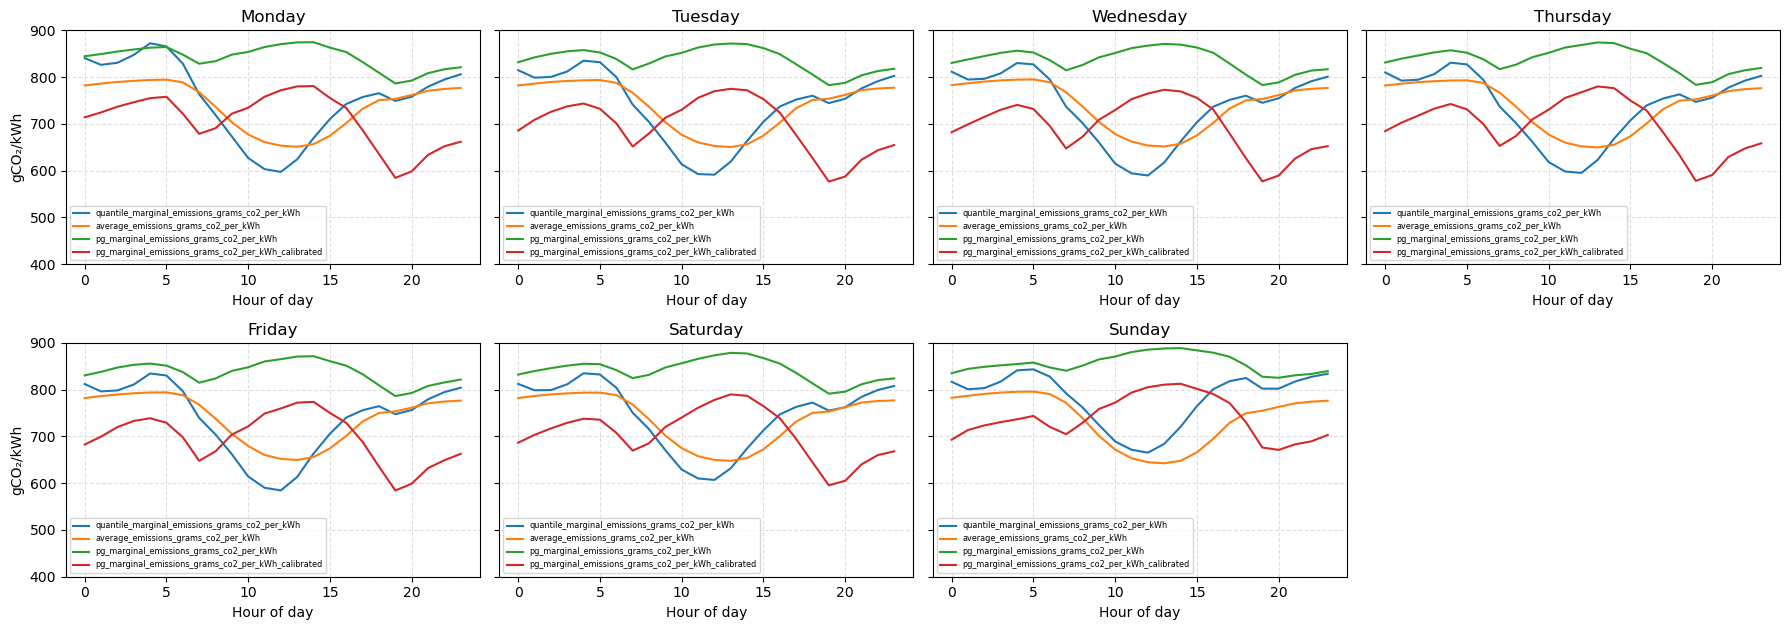

In [120]:
_ = plot_weekday_hourly_profiles(national_df,
                             time_col="timestamp",
                             ef_cols=[
                                 "quantile_marginal_emissions_grams_co2_per_kWh",
                                 "average_emissions_grams_co2_per_kWh",
                                 "pg_marginal_emissions_grams_co2_per_kWh",
                                 "pg_marginal_emissions_grams_co2_per_kWh_calibrated",
                             ],
                             y_label="gCO₂/kWh",
                             figsize_per_panel=(4.5, 3.2),
                             y_min = 400,
                             y_max = 900,
                             save_dir=None,
                             show=True,
                             legend_fontsize="xx-small"
                             )

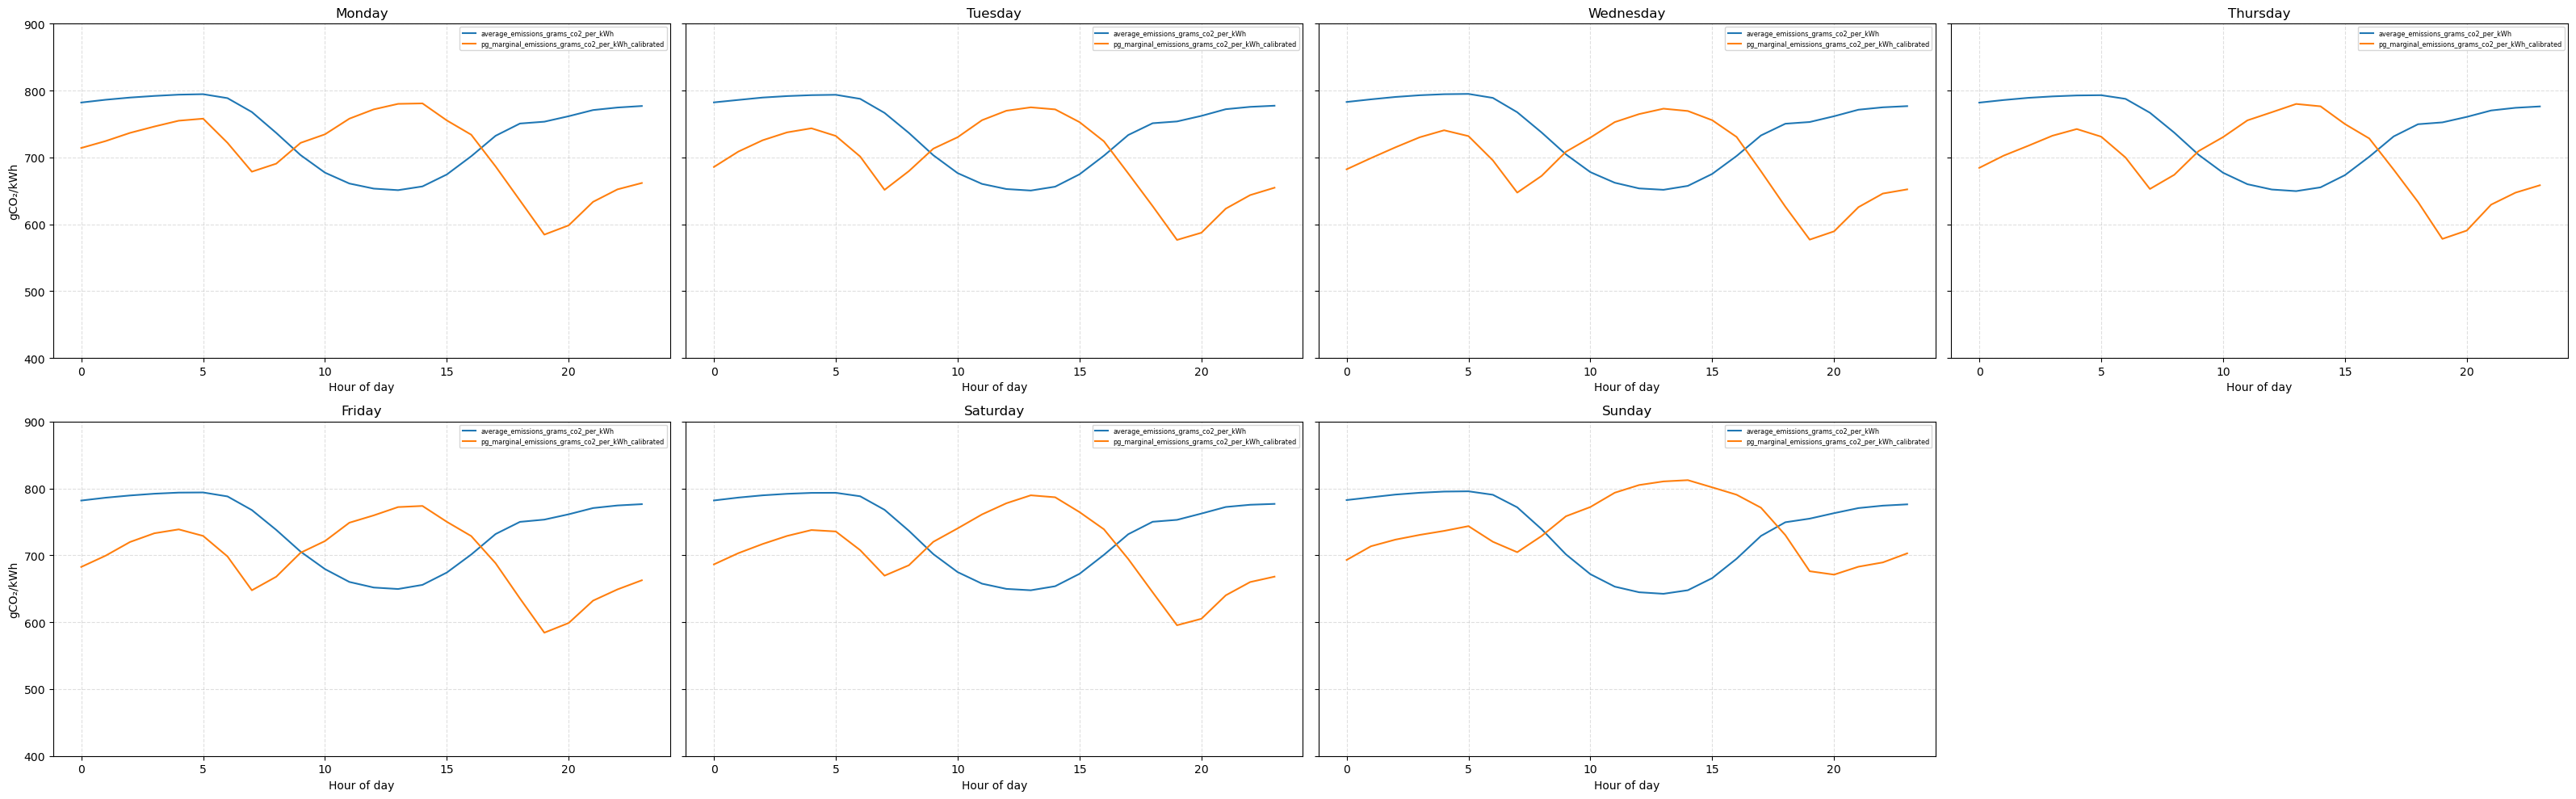

In [121]:
_ = plot_weekday_hourly_profiles(national_df,
                             time_col="timestamp",
                             ef_cols=[
                                 "average_emissions_grams_co2_per_kWh",
                                 "pg_marginal_emissions_grams_co2_per_kWh_calibrated",
                             ],
                             y_label="gCO₂/kWh",
                             figsize_per_panel=(8, 5),
                             y_min = 400,
                             y_max = 900,
                             save_dir=None,
                             show=True,
                             legend_fontsize="xx-small"
                             )

/var/folders/lg/rt7jvg4x71vd57p0zm_718200000gn/T/ipykernel_31305/3202857677.py:69: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if pd.api.types.is_datetime64tz_dtype(data[time_col]):
/var/folders/lg/rt7jvg4x71vd57p0zm_718200000gn/T/ipykernel_31305/3202857677.py:97: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if drop_tz_for_plot and pd.api.types.is_datetime64tz_dtype(x):


array([<Axes: title={'center': 'Average Emissions'}, xlabel='Time', ylabel='average_emissions_grams_co2_per_kWh'>,
       <Axes: title={'center': 'PG Marginal Emissions'}, xlabel='Time', ylabel='pg_marginal_emissions_grams_co2_per_kWh'>,
       <Axes: title={'center': 'PG Marginal Emissions (Calibrated)'}, xlabel='Time', ylabel='pg_marginal_emissions_grams_co2_per_kWh_calibrated'>],
      dtype=object)

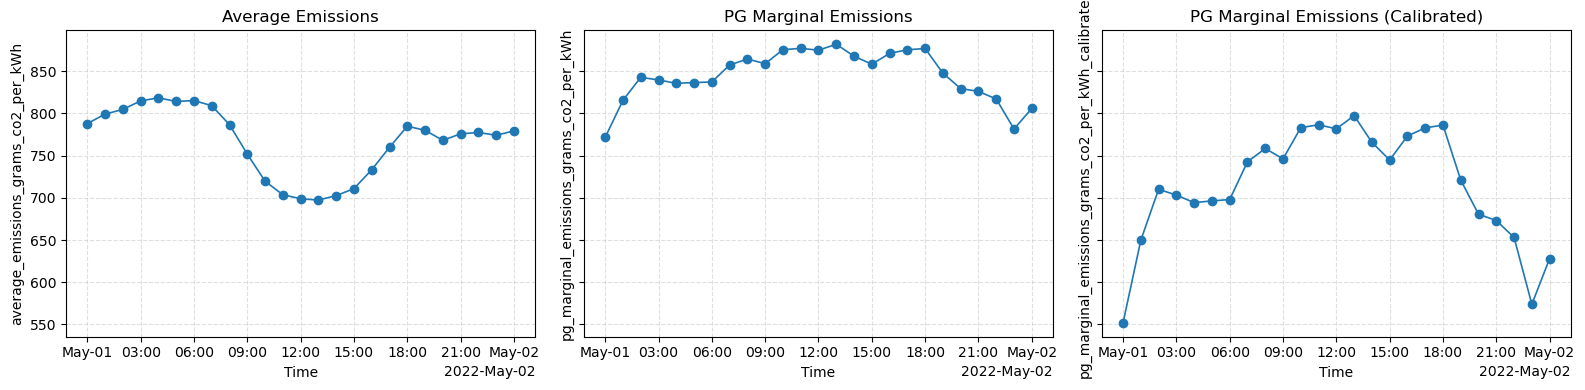

In [122]:
plot_three_timeseries_side_by_side(national_df_pd,
                                   time_col="timestamp",
                                   y_cols=["average_emissions_grams_co2_per_kWh", "pg_marginal_emissions_grams_co2_per_kWh", "pg_marginal_emissions_grams_co2_per_kWh_calibrated"],
                                   start="2022-05-01",
                                   end="2022-05-02",
                                   tz="Asia/Kolkata",
                                   titles=["Average Emissions", "PG Marginal Emissions", "PG Marginal Emissions (Calibrated)"],
                                   figsize=(16, 4),
                                   sharey=True,
                                   grid=True,
                                   linewidth=1.2,
                                   resample="h",
                                   dropna="any"

                                   )

In [123]:
national_df

timestamp,quantile_marginal_emissions_grams_co2_per_kWh,demand_met_kWh,average_emissions_grams_co2_per_kWh,pg_marginal_emissions_grams_co2_per_kWh,pg_marginal_emissions_grams_co2_per_kWh_calibrated,National MW Shift,Pearson R Score,Spearman Score,Confidence Level,city
"datetime[μs, Asia/Kolkata]",f64,f64,f64,f64,f64,f64,f64,f64,str,str
2021-10-27 11:30:00 IST,824.733163,3.5923e9,646.421619,905.222719,849.116295,2840.208333,0.55088,0.584222,"""medium""","""national"""
2024-10-25 07:00:00 IST,713.629561,4.0366e9,772.093341,802.531794,620.516028,3109.5,0.556189,0.587702,"""medium""","""national"""
2024-08-07 15:30:00 IST,727.843016,4.3447e9,566.633248,870.352364,771.491397,762.458333,0.417261,0.495056,"""medium""","""national"""
2022-04-08 20:00:00 IST,751.378739,4.1760e9,786.76205,755.868229,516.638265,782.125,0.419265,0.496435,"""medium""","""national"""
2024-10-24 08:00:00 IST,693.755301,4.1476e9,763.56242,834.435632,691.537161,5634.5,0.573359,0.616836,"""medium""","""national"""
…,…,…,…,…,…,…,…,…,…,…
2023-12-20 01:30:00 IST,970.043507,3.1445e9,825.450387,907.452231,854.079412,1624.333333,0.495565,0.548185,"""medium""","""national"""
2024-11-07 08:30:00 IST,673.512787,4.2179e9,746.953341,835.634559,694.206093,5977.625,0.575642,0.620793,"""medium""","""national"""
2024-01-14 15:30:00 IST,771.060699,4.0433e9,725.018488,887.01889,808.59275,2079.916667,0.531713,0.570677,"""medium""","""national"""


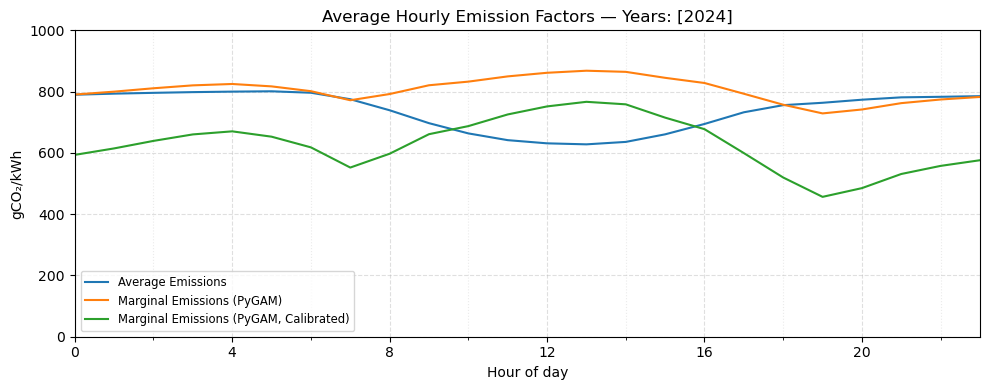

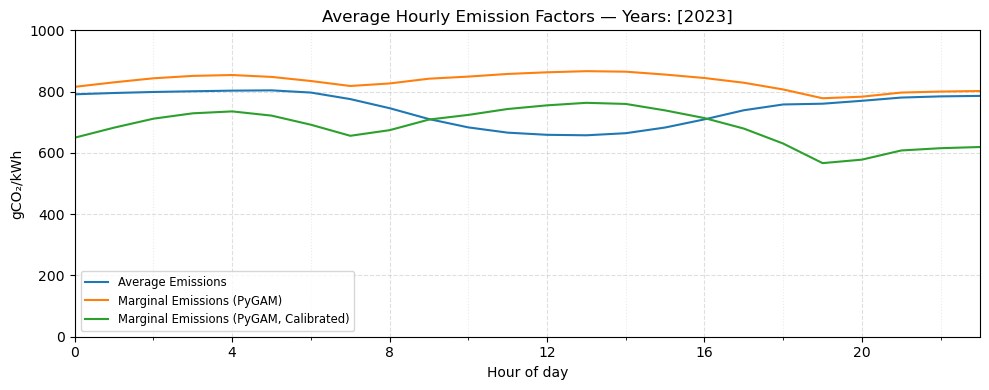

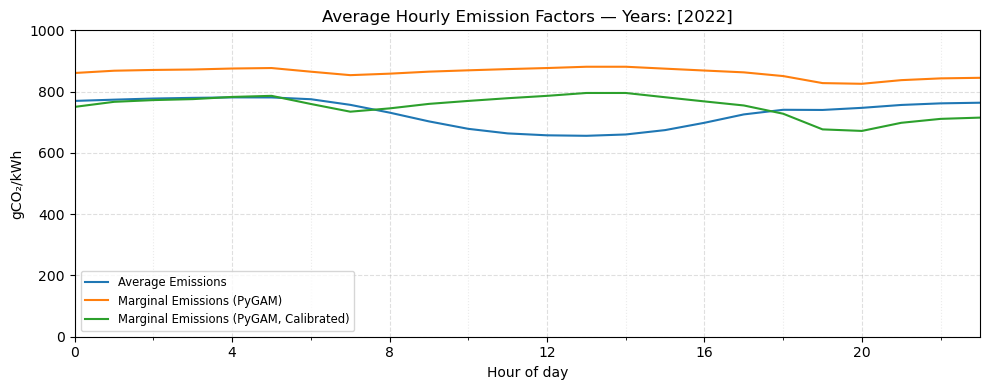

In [174]:
labels = {
    "average_emissions_grams_co2_per_kWh": "Average Emissions",
    "pg_marginal_emissions_grams_co2_per_kWh": "Marginal Emissions (PyGAM)",
    "pg_marginal_emissions_grams_co2_per_kWh_calibrated": "Marginal Emissions (PyGAM, Calibrated)",
    "quantile_marginal_emissions_grams_co2_per_kWh": "Marginal Emissions (Quantile)",
}

_ = plot_hourly_average_efs(
        national_df,
        years=2024,
        y_min=0, y_max=1000,
        exclude=["quantile_marginal_emissions_grams_co2_per_kWh"],
        legend_labels=labels,
        x_major_step=4,
        x_minor_step=2,
                legend_fontsize="small",
                legend_loc="lower left"
)

_ = plot_hourly_average_efs(
        national_df,
        years=2023,
        y_min=0, y_max=1000,
        exclude=["quantile_marginal_emissions_grams_co2_per_kWh"],
        legend_labels=labels,
        x_major_step=4,
        x_minor_step=2,
                legend_fontsize="small",
        legend_loc="lower left"
)

_ = plot_hourly_average_efs(
        national_df,
        years=2022,
        y_min=0, y_max=1000,
        exclude=["quantile_marginal_emissions_grams_co2_per_kWh"],
        legend_labels=labels,
        x_major_step=4,
        x_minor_step=2,
        legend_fontsize="small",
        legend_loc="lower left"
)


In [125]:
def prepare_usage_hourly(
    usage,                               # pd.DataFrame | pl.DataFrame | str (CSV path)
    *,
    time_col: str = "period",
    value_col: str = "per_customer_mean",
    tz: str = "Asia/Kolkata",
    years: int | tuple | list | None = None,   # e.g. 2021 or (2021,2022) or [2021]
    resample: str = "H",
) -> pd.DataFrame:
    """
    Return a pandas DataFrame with tz-aware datetime, filtered by `years` (if given),
    resampled to hourly, and with hour-of-day added.
    Columns: [time_col, value_col, 'year', 'hour'] (time_col is index).
    """
    # load
    if isinstance(usage, str):
        u = pd.read_csv(usage)
    elif isinstance(usage, pl.DataFrame):
        u = usage.to_pandas()
    else:
        u = usage.copy()

    # ensure datetime + tz
    if not pd.api.types.is_datetime64_any_dtype(u[time_col]):
        u[time_col] = pd.to_datetime(u[time_col], errors="coerce")
    if pd.api.types.is_datetime64tz_dtype(u[time_col]):
        u[time_col] = u[time_col].dt.tz_convert(tz)
    else:
        u[time_col] = u[time_col].dt.tz_localize(tz)

    # optional year filter
    if years is not None:
        if isinstance(years, int):
            years_list = [years]
        elif isinstance(years, tuple) and len(years) == 2:
            y0, y1 = sorted(map(int, years))
            years_list = list(range(y0, y1 + 1))
        else:
            years_list = sorted({int(y) for y in years})
        u = u[u[time_col].dt.year.isin(years_list)]

    # resample hourly mean (in case multiple rows per hour)
    u = (u.set_index(time_col)
           .resample(resample, label="left", origin="start_day")
           .mean(numeric_only=True))

    # add year/hour helpers
    u = u.assign(year=u.index.tz_convert(tz).year,
                 hour=u.index.tz_convert(tz).hour)

    return u[[value_col, "year", "hour"]]


In [126]:
avg_usage_dataset = pd.read_csv(filepath_or_buffer="outputs/metrics/all__per_customer_usage__hour.csv")
avg_usage_dataset_trans = prepare_usage_hourly(avg_usage_dataset)
avg_usage_dataset_trans.head(5)

/var/folders/lg/rt7jvg4x71vd57p0zm_718200000gn/T/ipykernel_31305/2729102126.py:26: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if pd.api.types.is_datetime64tz_dtype(u[time_col]):
/var/folders/lg/rt7jvg4x71vd57p0zm_718200000gn/T/ipykernel_31305/2729102126.py:43: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  u = (u.set_index(time_col)


,per_customer_mean,year,hour
period,,,
2021-12-01 00:00:00+05:30,0.171289,2021,0
2021-12-01 01:00:00+05:30,0.143754,2021,1
2021-12-01 02:00:00+05:30,0.130802,2021,2
2021-12-01 03:00:00+05:30,0.125988,2021,3
2021-12-01 04:00:00+05:30,0.130551,2021,4


In [127]:
def _fmt_years_for_title(years_list, ef_pdf, time_col):
    # if user didn't pass years, infer what's actually plotted
    if not years_list:
        years_list = sorted(ef_pdf[time_col].dt.year.unique().tolist())
    if len(years_list) == 1:
        return f"Year: [{years_list[0]}]"
    # contiguous range? show as range; else list
    if years_list == list(range(min(years_list), max(years_list)+1)):
        return f"Years: [{years_list[0]}–{years_list[-1]}]"
    return "Years: [" + ", ".join(map(str, years_list)) + "]"

In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import polars as pl

def plot_hourly_avg_efs_vs_usage(
    efs,                                  # pl.DataFrame | pl.LazyFrame | pd.DataFrame
    usage,                                # usage table; prepare_usage_hourly will auto-detect cols
    *,
    years,                                # int | list | tuple | None
    time_col: str = "timestamp",
    ef_cols = (
        "average_emissions_grams_co2_per_kWh",
        "pg_marginal_emissions_grams_co2_per_kWh_calibrated",
    ),
    tz: str = "Asia/Kolkata",

    # legend controls
    legend_labels: dict | None = None,    # map column->pretty label; also key "usage" for usage label
    legend_loc: str = "lower left",

    # x-axis tick density
    major_xtick_every: int = 4,
    minor_xtick_every: int = 2,

    # y-axis limits
    y_left_min: float | None = None,
    y_left_max: float | None = None,
    y_right_min: float | None = None,
    y_right_max: float | None = None,

    # usage bars (right axis)
    bar_alpha: float = 0.35,
    bar_width: float = 0.9,
    bar_color: str | None = None,        # None → matplotlib chooses
):
    """
    Overlay hourly mean EF curves (left y) with hourly mean usage as bars (right y).
    Filters both EF and usage to the same year(s), aggregates to hourly mean.
    """
    legend_labels = legend_labels or {}

    # ---- EF side: to pandas + filter + hourly means
    if isinstance(efs, pl.DataFrame):
        ef_pdf = efs.to_pandas()
    elif isinstance(efs, pl.LazyFrame):
        ef_pdf = efs.collect().to_pandas()
    else:
        ef_pdf = efs.copy()

    if not pd.api.types.is_datetime64_any_dtype(ef_pdf[time_col]):
        ef_pdf[time_col] = pd.to_datetime(ef_pdf[time_col], errors="coerce")

    if pd.api.types.is_datetime64tz_dtype(ef_pdf[time_col]):
        ef_pdf[time_col] = ef_pdf[time_col].dt.tz_convert(tz)
    else:
        ef_pdf[time_col] = ef_pdf[time_col].dt.tz_localize(tz)

    # normalize years filter
    years_list = None
    if years is not None:
        if isinstance(years, int):
            years_list = [years]
        elif isinstance(years, tuple) and len(years) == 2:
            y0, y1 = sorted(map(int, years))
            years_list = list(range(y0, y1 + 1))
        else:
            years_list = sorted({int(y) for y in years})
        ef_pdf = ef_pdf[ef_pdf[time_col].dt.year.isin(years_list)]

    present = [c for c in ef_cols if c in ef_pdf.columns]
    if not present:
        raise ValueError(f"None of ef_cols present. Got columns: {list(ef_pdf.columns)}")

    ef_hourly = (
        ef_pdf.assign(hour=ef_pdf[time_col].dt.hour)
              .groupby("hour")[present]
              .mean()
              .reindex(range(24))
    )

    # ---- Usage side: hourly means via your helper
    u = prepare_usage_hourly(
        usage,
        tz=tz,
        years=years_list,
        resample="h",
    )
    usage_hourly = (
        u.groupby("hour")["per_customer_mean"]
         .mean()
         .reindex(range(24))
    )

    # ---- Plot
    hours = np.arange(24)
    fig, ax1 = plt.subplots(figsize=(10, 4))

    # EF lines (left axis)
    line_handles = []
    line_labels  = []
    for col in present:
        (ln,) = ax1.plot(
            hours, ef_hourly[col].values,
            marker="o", linewidth=1.6, zorder=3,
            label=legend_labels.get(col, col)
        )
        line_handles.append(ln)
        line_labels.append(legend_labels.get(col, col))

    ax1.set_xlabel("Hour of day")
    ax1.set_ylabel("gCO₂/kWh")

    # left y-lims
    if y_left_min is not None or y_left_max is not None:
        ax1.set_ylim(bottom=y_left_min if y_left_min is not None else None,
                     top=y_left_max if y_left_max is not None else None)

    # ticks every 4h major, 2h minor (customizable)
    ax1.set_xticks(np.arange(0, 24, major_xtick_every))
    ax1.xaxis.set_minor_locator(ticker.MultipleLocator(minor_xtick_every))
    ax1.grid(True, axis="both", which="major", linestyle="--", alpha=0.4)
    ax1.grid(True, axis="x", which="minor", linestyle=":", alpha=0.25)

    # Usage bars (right axis)
    ax2 = ax1.twinx()
    bar_lbl = legend_labels.get("usage", "Average Usage (kWh)")
    bars = ax2.bar(
        hours, usage_hourly.values,
        width=bar_width, alpha=bar_alpha, label=bar_lbl,
        color=bar_color, edgecolor="none", zorder=1, align="center"
    )
    ax2.set_ylabel(bar_lbl)

    # right y-lims
    if y_right_min is not None or y_right_max is not None:
        ax2.set_ylim(bottom=y_right_min if y_right_min is not None else None,
                     top=y_right_max if y_right_max is not None else None)

    # Combine legends (lines + bars) and place where you want
    handles = line_handles + [bars]
    labels  = line_labels  + [bar_lbl]

    # de-duplicate by label (keeps first)
    uniq_h, uniq_l = [], []
    seen = set()
    for h, l in zip(handles, labels):
        if l not in seen:
            uniq_h.append(h); uniq_l.append(l); seen.add(l)

    ax1.legend(uniq_h, uniq_l, loc=legend_loc, frameon=False)
    fig.tight_layout()
    title_str = _fmt_years_for_title(years_list, ef_pdf, time_col)
    ax1.set_title(f"Average Hourly Emission Factors and Customer Usage — {title_str}")
    fig.tight_layout()

    # Return the hourly tables in case you want to inspect/save
    out = pd.DataFrame({"hour": hours}).set_index("hour")
    for col in present:
        out[col] = ef_hourly[col].values
    out["usage_value"] = usage_hourly.values
    return out


/var/folders/lg/rt7jvg4x71vd57p0zm_718200000gn/T/ipykernel_31305/3583170045.py:55: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if pd.api.types.is_datetime64tz_dtype(ef_pdf[time_col]):
/var/folders/lg/rt7jvg4x71vd57p0zm_718200000gn/T/ipykernel_31305/2729102126.py:26: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if pd.api.types.is_datetime64tz_dtype(u[time_col]):
/var/folders/lg/rt7jvg4x71vd57p0zm_718200000gn/T/ipykernel_31305/3583170045.py:55: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if pd.api.types.is_datetime64tz_dtype(ef_pdf[time_col]):
/var/folders/lg/rt7jvg4x71vd57p0zm_718200000gn/T/ipykernel_31305/2729102126.py:26: DeprecationWarning: is_datetime64tz_dtyp

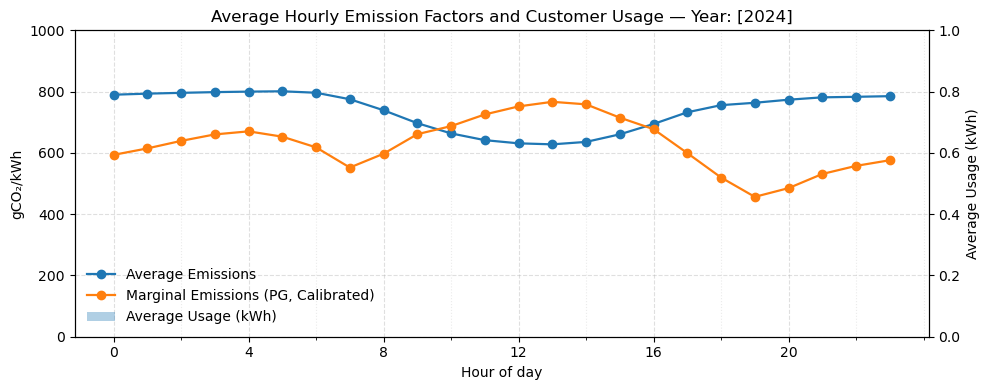

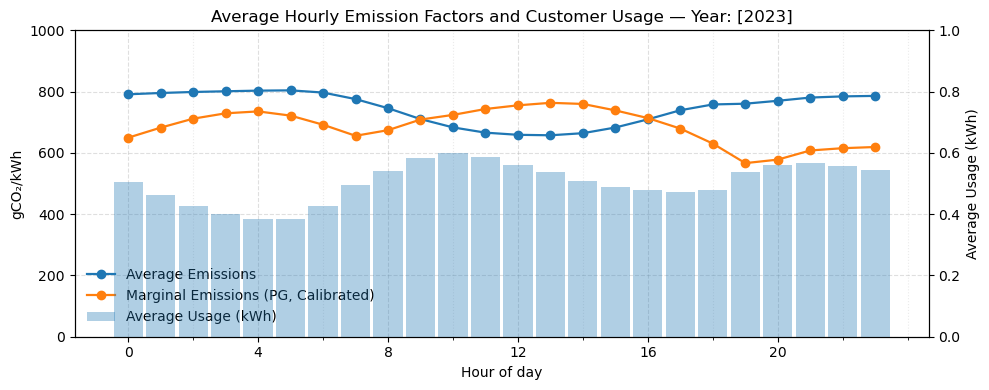

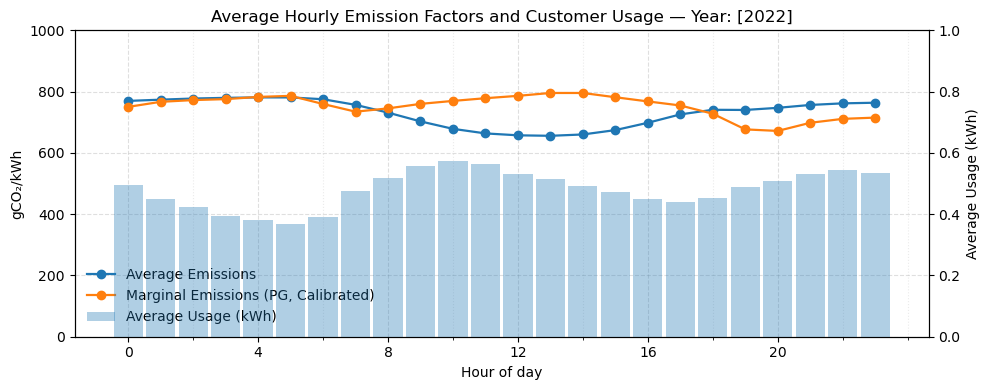

In [ ]:
hourly_profile2 = plot_hourly_avg_efs_vs_usage(
    national_df,
    avg_usage_dataset,                                     # your two-column DataFrame
    years=2024,
    legend_labels={"per_customer_mean":"Usage/customer",     "average_emissions_grams_co2_per_kWh": "Average Emissions",
    "pg_marginal_emissions_grams_co2_per_kWh_calibrated": "Marginal Emissions (PG, Calibrated)"},
    y_left_min=0,  y_left_max=1000,   # left axis bounds
    y_right_min=0.0, y_right_max=1.0, # right axis bounds
    legend_loc="lower left",
    major_xtick_every=4,
    minor_xtick_every=2,
    bar_alpha=0.35,
    bar_width=0.9,
)

hourly_profile2 = plot_hourly_avg_efs_vs_usage(
    national_df,
    avg_usage_dataset,                                     # your two-column DataFrame
    years=2023,
    legend_labels={"per_customer_mean":"Usage/customer",     "average_emissions_grams_co2_per_kWh": "Average Emissions",
    "pg_marginal_emissions_grams_co2_per_kWh_calibrated": "Marginal Emissions (PG, Calibrated)"},
    y_left_min=0,  y_left_max=1000,   # left axis bounds
    y_right_min=0.0, y_right_max=1.0, # right axis bounds
    legend_loc="lower left",
    major_xtick_every=4,
    minor_xtick_every=2,
    bar_alpha=0.35,
    bar_width=0.9,
)

hourly_profile2 = plot_hourly_avg_efs_vs_usage(
    national_df,
    avg_usage_dataset,                                     # your two-column DataFrame
    years=2022,
    legend_labels={"per_customer_mean":"Usage/customer",     "average_emissions_grams_co2_per_kWh": "Average Emissions",
    "pg_marginal_emissions_grams_co2_per_kWh_calibrated": "Marginal Emissions (PG, Calibrated)"},
    y_left_min=0,  y_left_max=1000,   # left axis bounds
    y_right_min=0.0, y_right_max=1.0, # right axis bounds
    legend_loc="lower left",
    major_xtick_every=4,
    minor_xtick_every=2,
    bar_alpha=0.35,
    bar_width=0.9,
)
# hourly_profile2 = plot_hourly_avg_efs_vs_usage(
#     national_df,
#     avg_usage_dataset,                                     # your two-column DataFrame
#     years=2021,
#     legend_labels={"per_customer_mean":"Usage/customer",     "average_emissions_grams_co2_per_kWh": "Average Emissions",
#     "pg_marginal_emissions_grams_co2_per_kWh_calibrated": "Marginal Emissions (PG, Calibrated)"},
#     y_left_min=0,  y_left_max=1000,   # left axis bounds
#     y_right_min=0.0, y_right_max=1.0, # right axis bounds
#     legend_loc="lower left",
#     major_xtick_every=4,
#     minor_xtick_every=2,
#     bar_alpha=0.35,
#     bar_width=0.9,
# )


#  AverageHourlyEmissionFactorsAndCustomerUsageByYear

In [130]:
avg_usage_dataset

,period,per_customer_mean
0,2021-12-01T00:00:00.000000,0.171289
1,2021-12-01T01:00:00.000000,0.143754
2,2021-12-01T02:00:00.000000,0.130802
3,2021-12-01T03:00:00.000000,0.125988
4,2021-12-01T04:00:00.000000,0.130551
...,...,...
8322,2023-03-27T20:00:00.000000,0.289945
8323,2023-03-27T21:00:00.000000,0.654321
8324,2023-03-27T22:00:00.000000,0.612580
8325,2023-03-27T23:00:00.000000,0.624362


#### Monthly Trends

/var/folders/lg/rt7jvg4x71vd57p0zm_718200000gn/T/ipykernel_31305/1547995604.py:145: MatplotlibDeprecationWarning: You have mixed positional and keyword arguments, some input may be discarded.  This is deprecated since 3.9 and will become an error in 3.11.
  fig.legend([h for h in legend_handles[:len(present_cols)]],


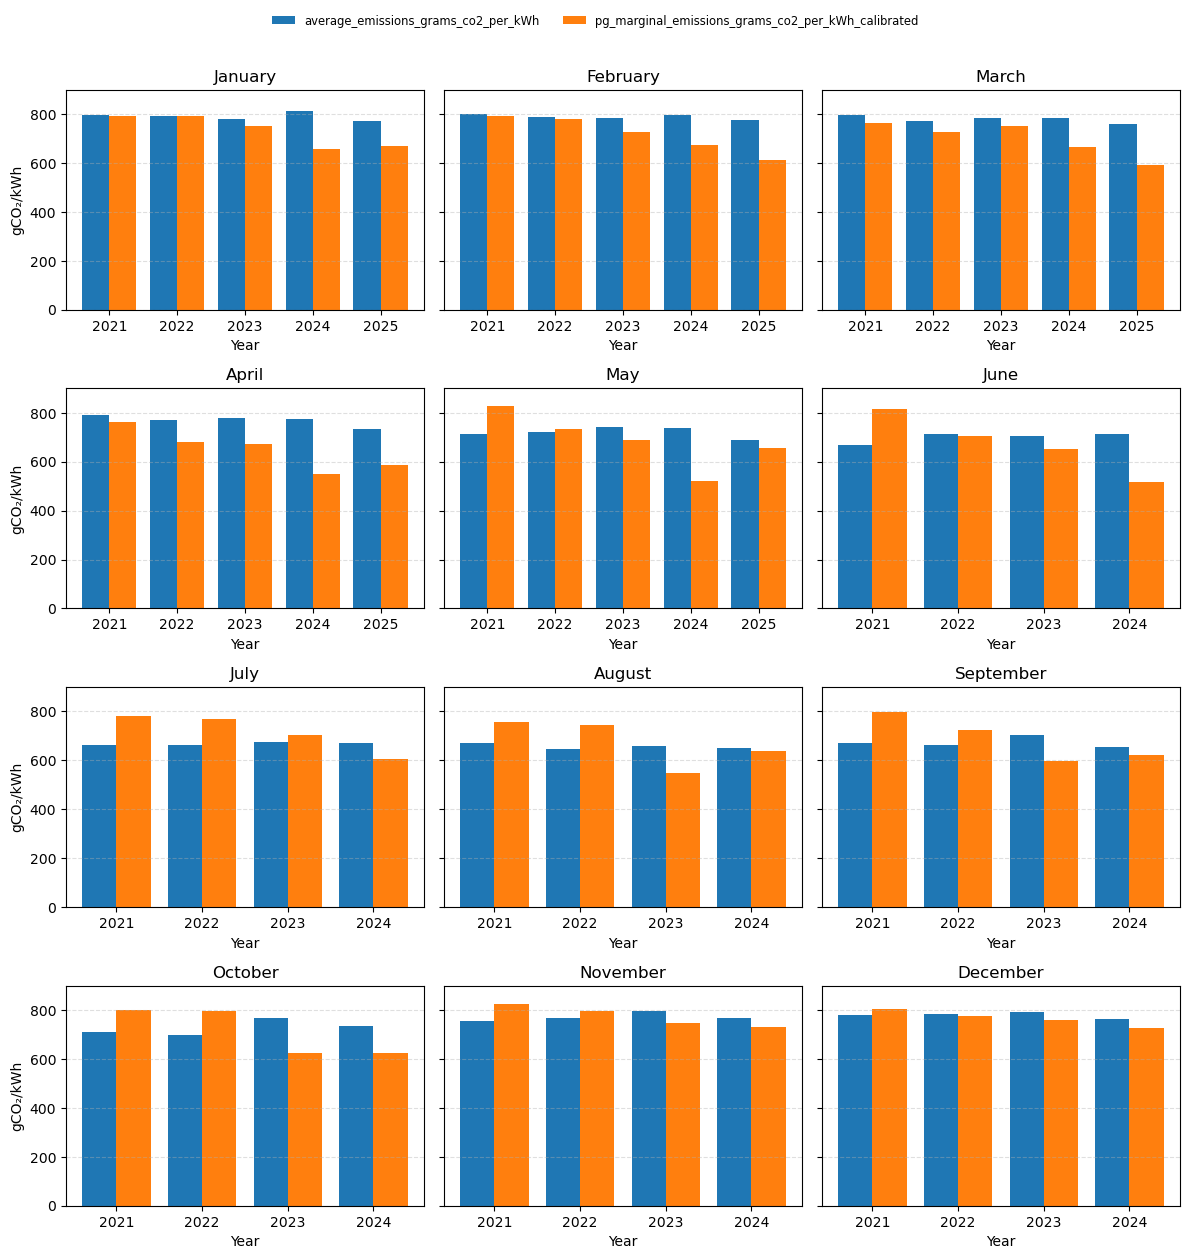

In [131]:
ef_cols = [
    # "quantile_marginal_emissions_grams_co2_per_kWh",
    "average_emissions_grams_co2_per_kWh",
    # "pg_marginal_emissions_grams_co2_per_kWh",
    "pg_marginal_emissions_grams_co2_per_kWh_calibrated",
]

monthly_facets_year_grouped_bars(
    national_df,
    ef_cols=ef_cols,
    y_min_zero=True,    # pin baseline
    y_max=900,         # or set e.g. 1000 for fixed upper bound
    legend_fontsize="small",
    figsize_per_panel=(4.0, 3.0),
    sharey=True,
    legend_top=True
);


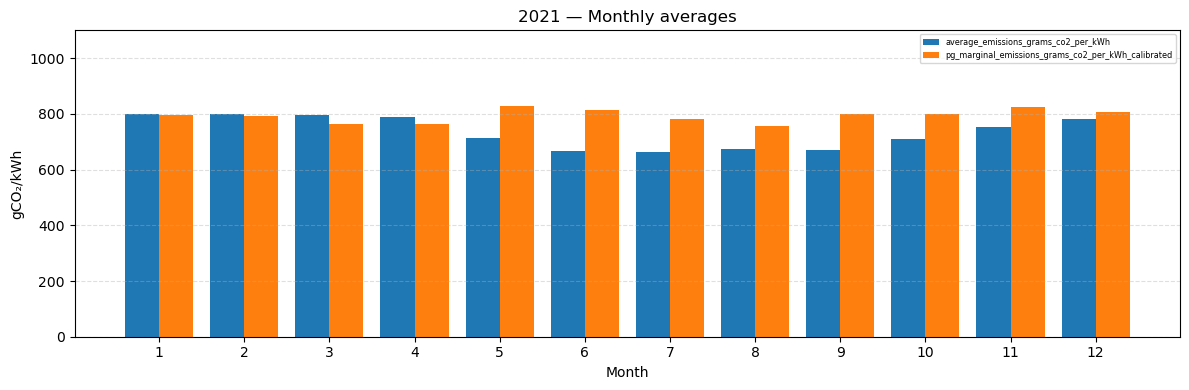

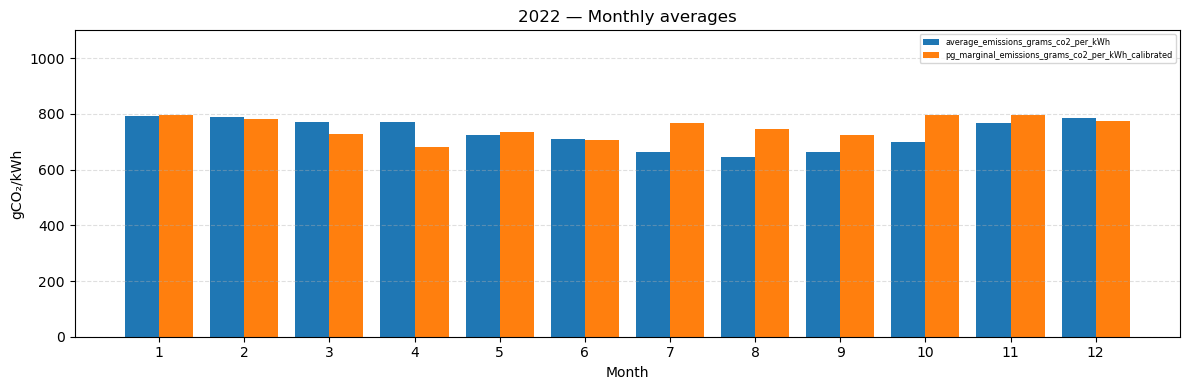

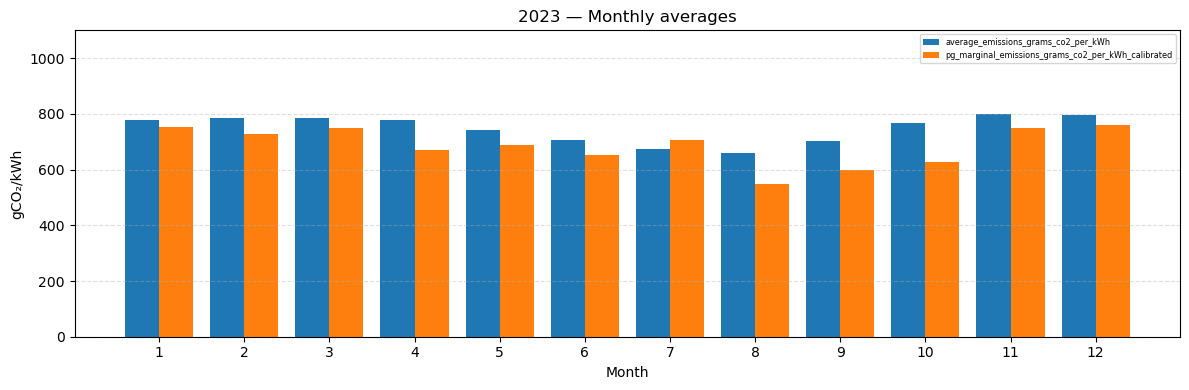

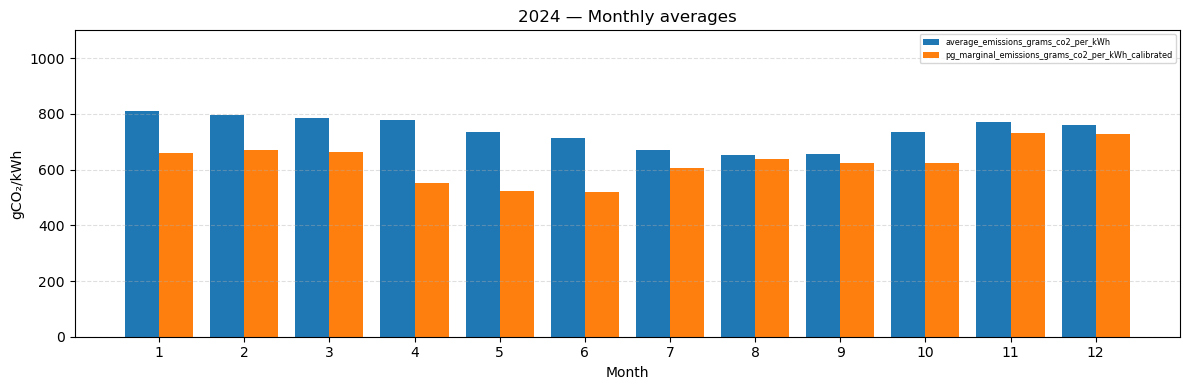

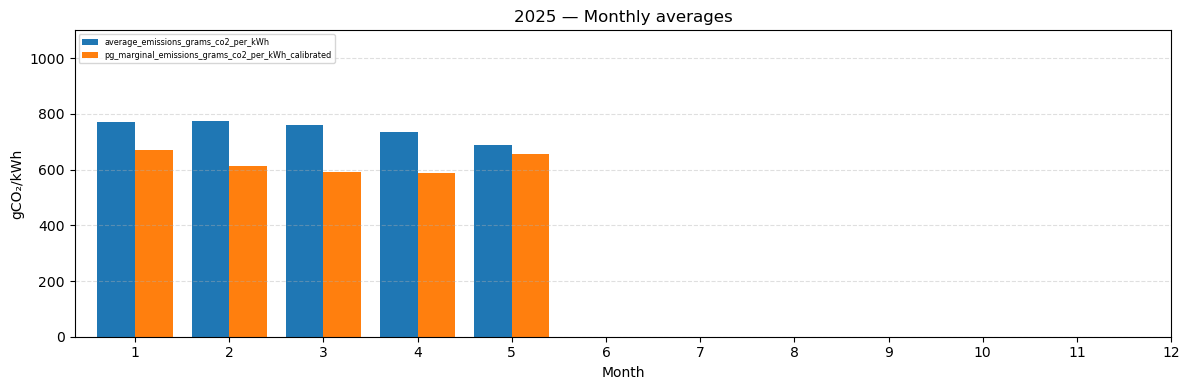

In [132]:
monthly_grouped_bars_per_year(
    national_df,
    ef_cols=ef_cols,
    y_min_zero=True,
    y_max=1100,
    legend_fontsize="xx-small",
    figsize=(12,4)
);


In [133]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.lines import Line2D

def plot_hourly_avg_vs_marginal_by_year(
    df, *,
    time_candidates=("timestamp","mestamp","time"),
    avg_col="average_emissions_grams_co2_per_kWh",
    marginal_col="pg_marginal_emissions_grams_co2_per_kWh_calibrated",
    years=None,                         # int | list | tuple | None
    tz=None,                            # optional; if provided and timestamps are naive, localize
    figsize=(12,4),
    y_label="gCO₂/kWh",
    y_min_zero=False,
    y_min=None, y_max=None,
    major_xtick_every=4,
    minor_xtick_every=2,
    legend_fontsize="x-small",
    year_legend_loc="upper right",
    style_legend_loc="lower left",
    title=None,
):
    """
    One panel: for each year -> same color; Average = solid line, Marginal = dotted line.
    """
    # --- resolve to pandas + time col ---
    pdf = df.to_pandas() if hasattr(df, "to_pandas") else (df.collect().to_pandas() if hasattr(df, "collect") else df.copy())
    TIME = next((c for c in time_candidates if c in pdf.columns), None)
    if TIME is None:
        raise KeyError(f"Couldn't find a time column in {time_candidates}. Got: {list(pdf.columns)}")

    # ensure datetime
    if not pd.api.types.is_datetime64_any_dtype(pdf[TIME]):
        pdf[TIME] = pd.to_datetime(pdf[TIME], errors="coerce")

    # optional tz handling (affects hour-of-day)
    if tz is not None:
        if pd.api.types.is_datetime64tz_dtype(pdf[TIME]):
            pdf[TIME] = pdf[TIME].dt.tz_convert(tz)
        else:
            pdf[TIME] = pdf[TIME].dt.tz_localize(tz)

    # filter years
    if years is None:
        years_list = sorted(pdf[TIME].dt.year.dropna().unique().tolist())
    else:
        if isinstance(years, int):
            years_list = [years]
        elif isinstance(years, tuple) and len(years) == 2:
            y0, y1 = sorted(map(int, years))
            years_list = list(range(y0, y1+1))
        else:
            years_list = sorted({int(y) for y in years})
        pdf = pdf[pdf[TIME].dt.year.isin(years_list)]

    # sanity: columns
    for c in (avg_col, marginal_col):
        if c not in pdf.columns:
            raise KeyError(f"Column '{c}' not found. Available: {list(pdf.columns)}")

    # hourly means per year
    pdf["_year"] = pdf[TIME].dt.year
    pdf["_hour"] = pdf[TIME].dt.hour
    agg = (pdf.groupby(["_year","_hour"])[[avg_col, marginal_col]]
             .mean()
             .reset_index())

    hours = np.arange(24)

    # --- plot ---
    fig, ax = plt.subplots(figsize=figsize)

    # color cycle
    colors = plt.rcParams["axes.prop_cycle"].by_key().get("color", ["C0","C1","C2","C3","C4","C5"])

    # draw lines
    for i, yr in enumerate(years_list):
        color = colors[i % len(colors)]
        sub = agg[agg["_year"] == yr].set_index("_hour").reindex(hours)
        ax.plot(hours, sub[avg_col].values, color=color, linewidth=1.8, linestyle="-",  label=f"{yr} avg")
        ax.plot(hours, sub[marginal_col].values, color=color, linewidth=1.8, linestyle=":",  label=f"{yr} marg")

    ax.set_xlabel("Hour of day")
    ax.set_ylabel(y_label)

    # y-lims
    if (y_min is not None) or (y_max is not None) or y_min_zero:
        lo = 0.0 if y_min_zero and (y_min is None) else y_min
        ax.set_ylim(bottom=lo, top=y_max)

    # ticks
    ax.set_xticks(np.arange(0, 24, major_xtick_every))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(minor_xtick_every))
    ax.grid(True, which="major", axis="both", linestyle="--", alpha=0.4)
    ax.grid(True, which="minor", axis="x", linestyle=":",  alpha=0.25)

    # legends: colors = years; styles = series
    year_handles = [Line2D([0],[0], color=colors[i % len(colors)], lw=2, label=str(yr))
                    for i, yr in enumerate(years_list)]
    style_handles = [
        Line2D([0],[0], color="black", lw=2, linestyle="-", label="Average (solid)"),
        Line2D([0],[0], color="black", lw=2, linestyle=":", label="Marginal (dotted)")
    ]
    leg1 = ax.legend(handles=year_handles, title="Years", loc=year_legend_loc,
                     ncol=min(4, len(years_list)), frameon=False, fontsize=legend_fontsize)
    ax.add_artist(leg1)
    ax.legend(handles=style_handles, title="Series", loc=style_legend_loc,
              frameon=False, fontsize=legend_fontsize)

    # title
    if title is None:
        if len(years_list) == 1:
            title = f"Hourly Average vs Marginal Emission Factors — Year {years_list[0]}"
        elif years_list == list(range(min(years_list), max(years_list)+1)):
            title = f"Hourly Average vs Marginal Emission Factors — {years_list[0]}–{years_list[-1]}"
        else:
            title = "Hourly Average vs Marginal Emission Factors"
    ax.set_title(title)

    fig.tight_layout()
    return agg  # return the hourly-by-year means if you want to inspect


/var/folders/lg/rt7jvg4x71vd57p0zm_718200000gn/T/ipykernel_31305/4279659053.py:40: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if pd.api.types.is_datetime64tz_dtype(pdf[TIME]):


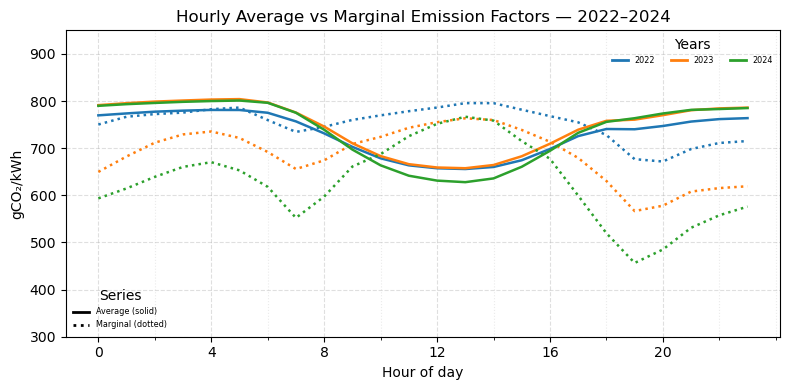

In [145]:
_ = plot_hourly_avg_vs_marginal_by_year(
    national_df,
    avg_col="average_emissions_grams_co2_per_kWh",
    marginal_col="pg_marginal_emissions_grams_co2_per_kWh_calibrated",
    years=(2022, 2024),        # any int | list | tuple | None
    tz="Asia/Kolkata",         # optional; only matters for hour-of-day
    figsize=(8,4),
    y_min_zero=False,
    y_min=300,
    y_max=950,
    legend_fontsize="xx-small",
    year_legend_loc="upper right",
    style_legend_loc="lower left",
)


#### Annual Analysis

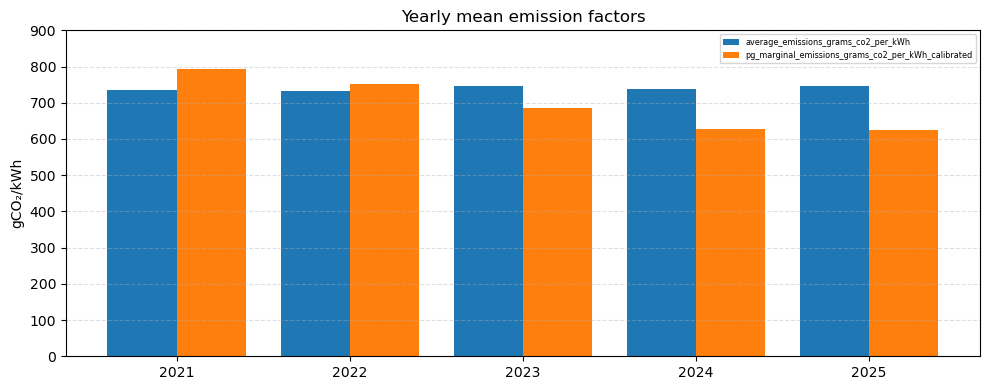

In [ ]:
yr = yearly_means(national_df, ef_cols=ef_cols)
plot_grouped_bars(
    yr,
    group_col="year",
    value_cols=ef_cols,
    title="Yearly mean emission factors",
    y_min_zero=True,   # pin to 0 if you like
    y_max=900,        # set a number to cap it globally
    legend_fontsize="xx-small",
    figsize=(10,4)
)


/var/folders/lg/rt7jvg4x71vd57p0zm_718200000gn/T/ipykernel_31305/4035956528.py:110: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=[str(yr) for yr in years], showfliers=False)
/var/folders/lg/rt7jvg4x71vd57p0zm_718200000gn/T/ipykernel_31305/4035956528.py:110: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=[str(yr) for yr in years], showfliers=False)


array([<Axes: title={'center': 'Average emission factors'}, xlabel='Year', ylabel='gCO₂/kWh'>,
       <Axes: title={'center': 'Marginal emission factors'}, xlabel='Year', ylabel='gCO₂/kWh'>],
      dtype=object)

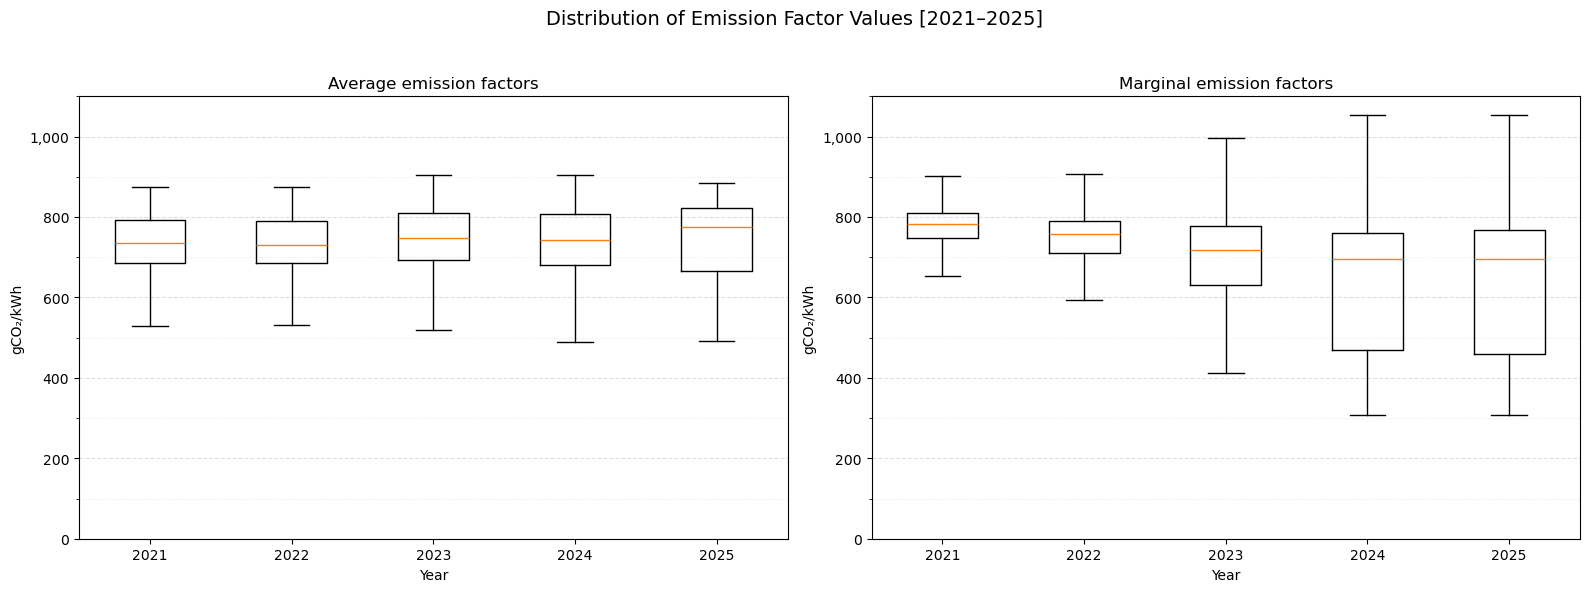

In [ ]:
boxplots_by_year(
    national_df,
    ef_cols=ef_cols,
    cols_per_row=2,        # grid of subplots
    y_min_zero=True,
    y_max=1100,            # set if you want uniform upper bound
    figsize_per_panel=(8,6),
    show
)


#### Confidence Levels

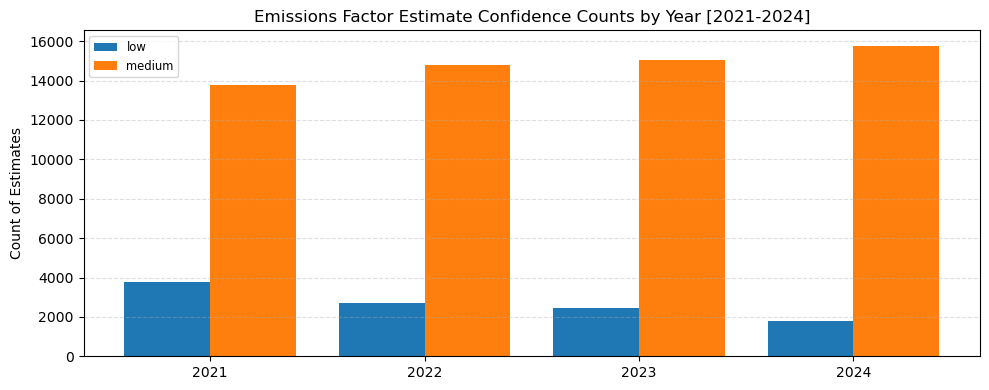

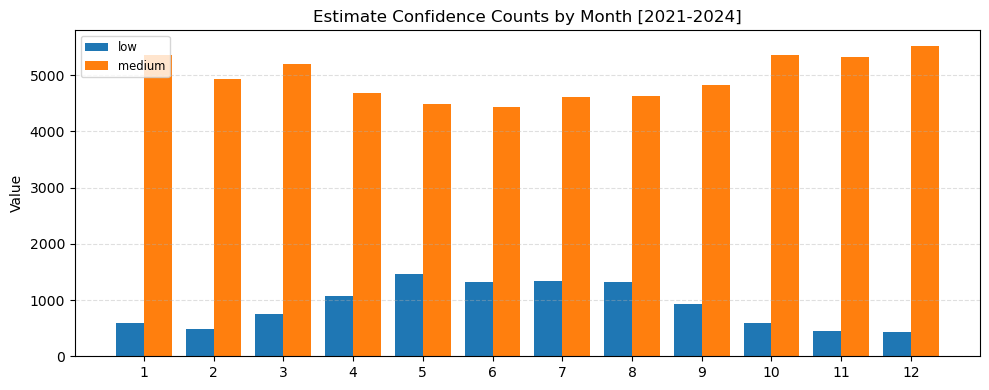

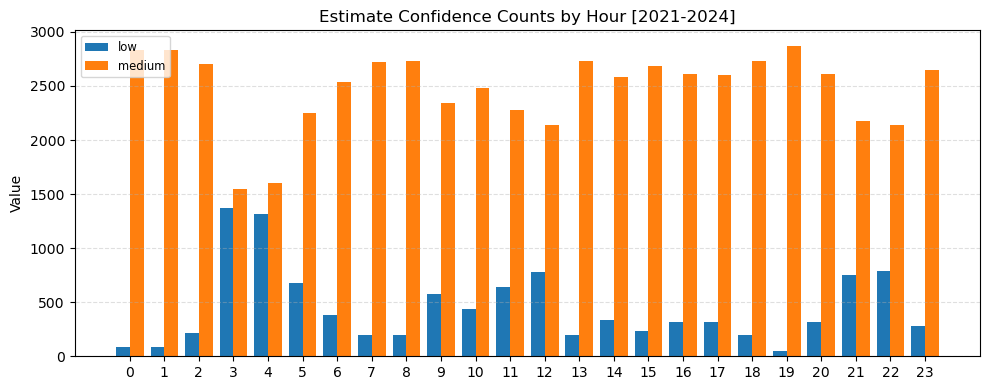

In [178]:
# Choose your categories (default low/high).
cats = ("low","medium")

# filter out 2025
national_df_filter = national_df.filter(pl.col("timestamp").dt.year() < 2025)

# 1) By YEAR (all years)
year_counts = confidence_counts(national_df_filter, period="year", categories=cats)
plot_conf_grouped_bars(
    year_counts,
    group_col="year",
    categories=cats,
    title="Emissions Factor Estimate Confidence Counts by Year [2021-2024]",
    y_label="Count of Estimates",
    y_min=0
);

# 2) By MONTH (aggregated across all years)
month_counts = confidence_counts(national_df_filter, period="month", categories=cats)
plot_conf_grouped_bars(
    month_counts,
    group_col="month",
    categories=cats,
    title="Estimate Confidence Counts by Month [2021-2024]",
    y_min=0
);

# 3) By HOUR (aggregated across all years)
hour_counts = confidence_counts(national_df_filter, period="hour", categories=cats)
plot_conf_grouped_bars(
    hour_counts,
    group_col="hour",
    categories=cats,
    title="Estimate Confidence Counts by Hour [2021-2024]",
    y_min=0
);


/var/folders/lg/rt7jvg4x71vd57p0zm_718200000gn/T/ipykernel_31305/625600726.py:106: MatplotlibDeprecationWarning: You have mixed positional and keyword arguments, some input may be discarded.  This is deprecated since 3.9 and will become an error in 3.11.
  fig.legend(handles, labels=present, loc="upper center",


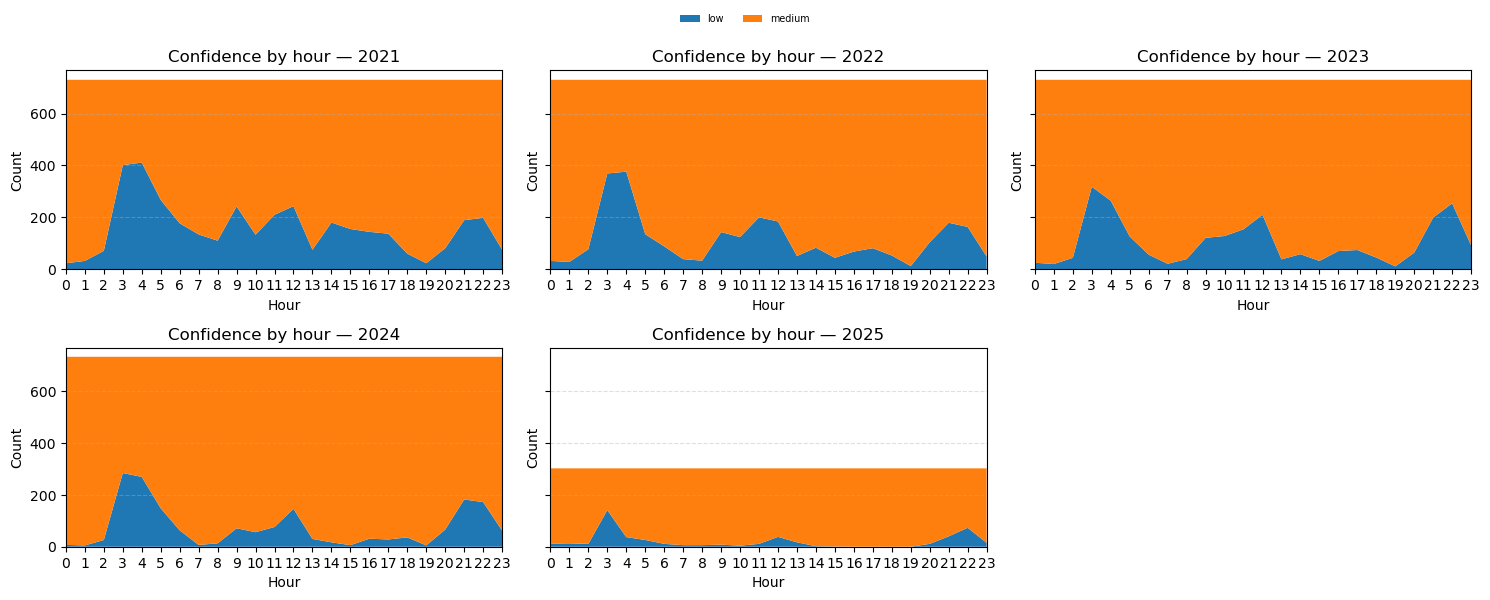

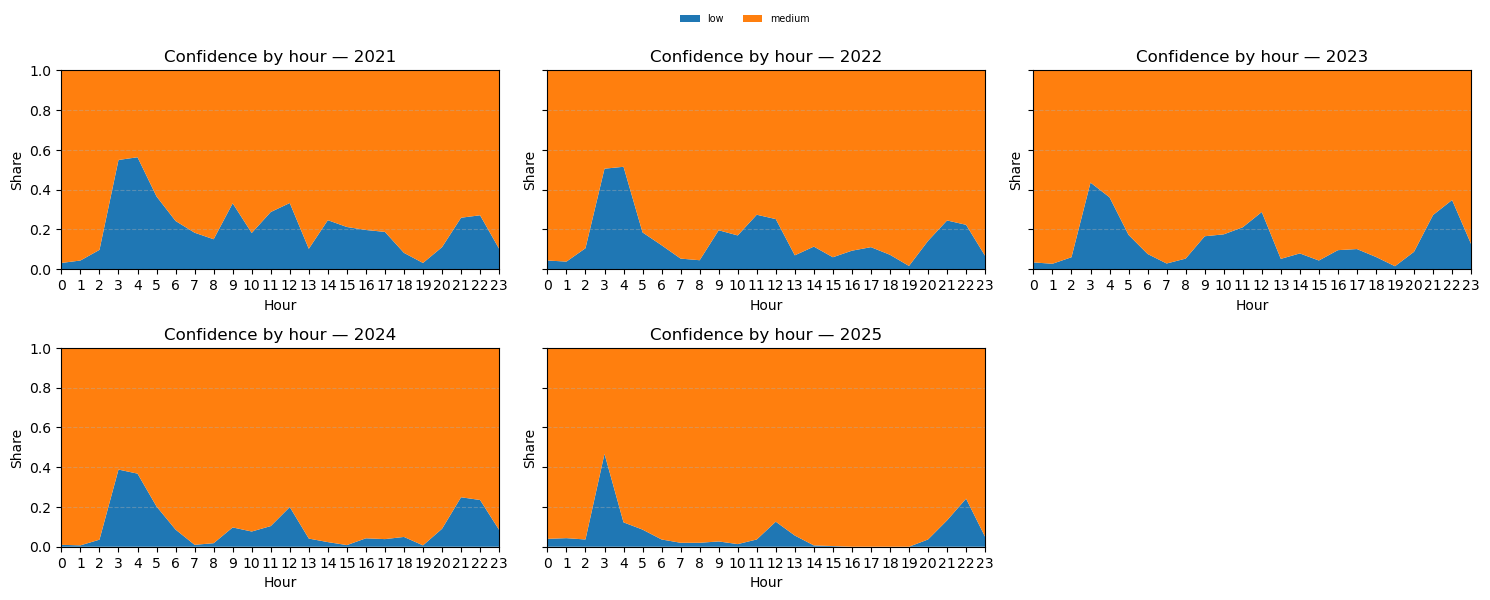

In [140]:
# 1) Get per-year, per-hour counts (reuse from earlier)
cats = ("low", "medium")  # add "high" if present
counts = confidence_counts_by_hour_per_year(national_df, categories=cats)

# 2a) Stacked area of COUNTS
_ = plot_conf_stacked_area_hour_facets_by_year(
    counts, categories=cats, normalize=False, ncols=3, figsize_per_panel=(5,3), y_min=0
)

# 2b) Stacked area of SHARES (areas sum to 1 in each subplot)
_ = plot_conf_stacked_area_hour_facets_by_year(
    counts, categories=cats, normalize=True, ncols=3, figsize_per_panel=(5,3)
)


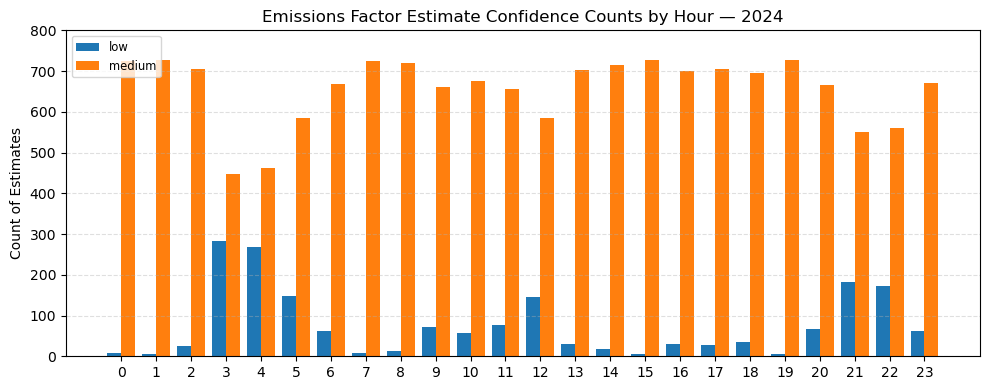

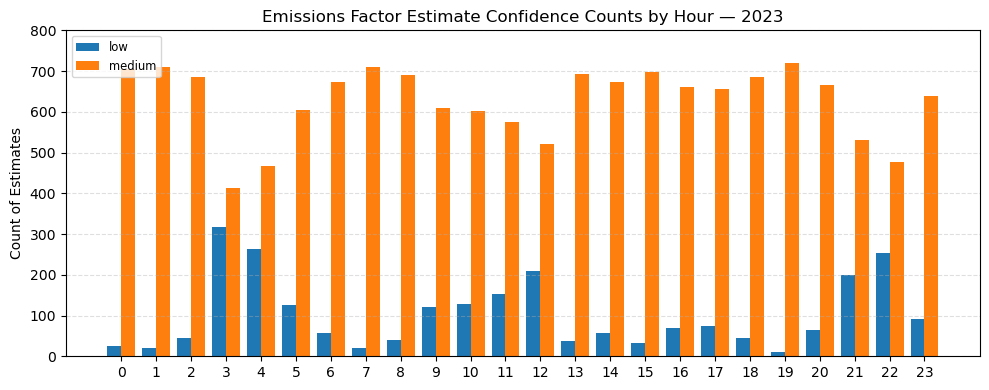

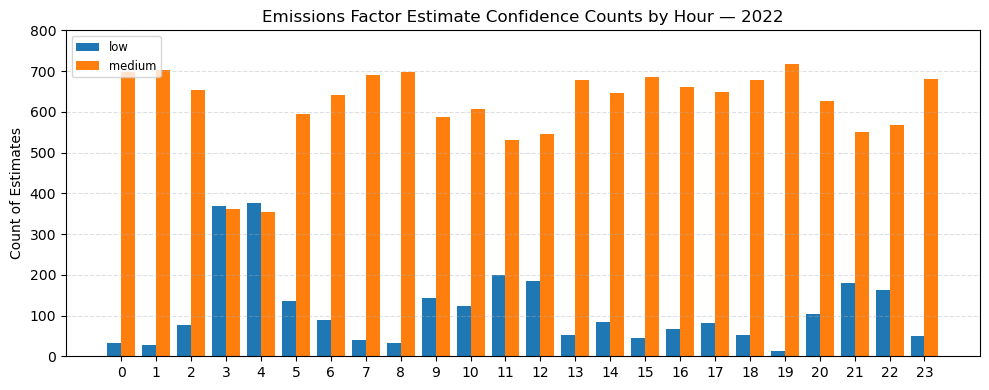

In [177]:
cats = ("low", "medium")  # include "high" too if you want

years = [2024, 2023, 2022]

for yr in years:
    by_hour = confidence_counts(
        national_df, period="hour", categories=cats, years=yr
    )
    plot_conf_grouped_bars(
        by_hour,
        group_col="hour",
        categories=cats,
        title=f"Emissions Factor Estimate Confidence Counts by Hour — {yr}",
        y_label="Count of Estimates",
        y_min=0,
        y_max=800
    )

In [162]:
# Only 2025
year_counts_2025 = confidence_counts(national_df, period="year", categories=cats, years=2024)
# 2024–2025 inclusive
month_counts_2425 = confidence_counts(national_df, period="month", categories=cats, years=(2024, 2025))
hour_counts_list  = confidence_counts(national_df, period="hour", categories=cats, years=[2023])


#### Confidence Weighted By _Category_


<Axes: title={'center': 'Demand-weighted share by confidence (hour)'}, ylabel='Share of demand'>

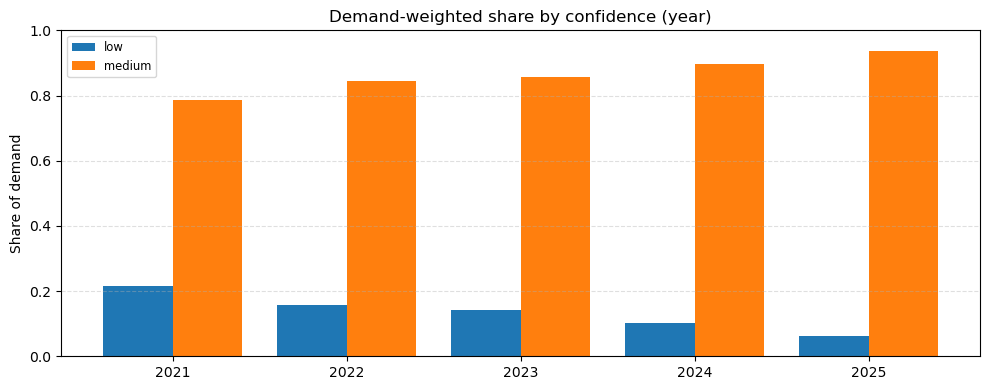

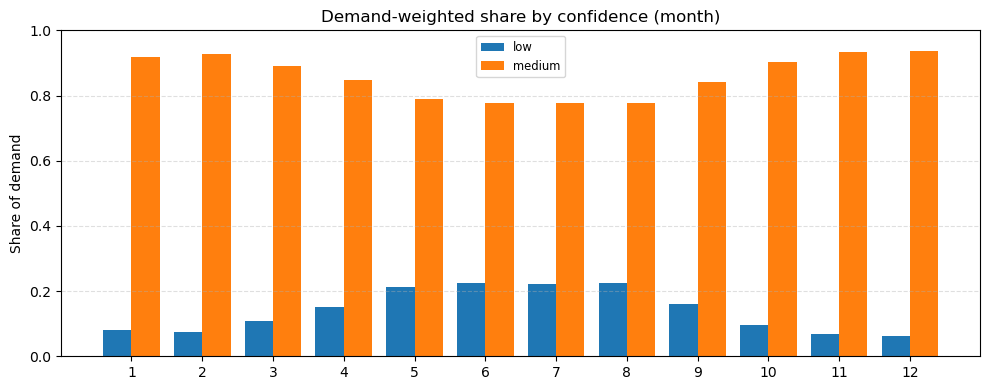

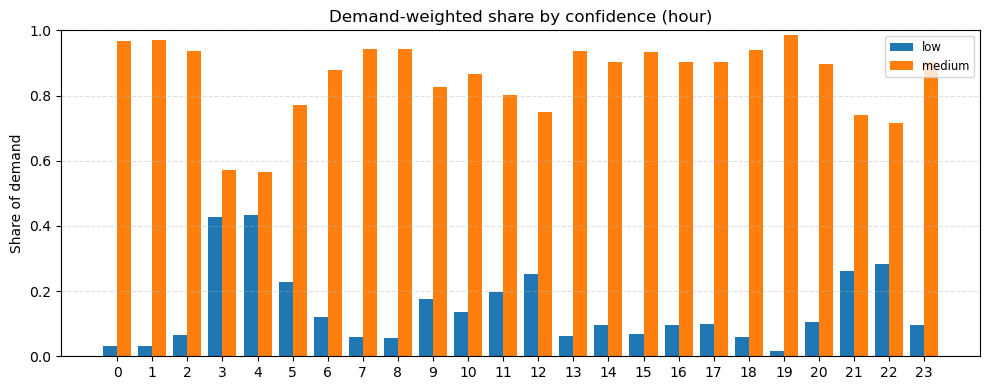

In [163]:
cats = ("low","medium")  # add "medium" if you want all three

by_year = confidence_weighted_by(
    national_df,
    period="year",
    categories=cats,
    weight_candidates=("demand_met_kWh",),
    use_abs_weight=False,     # demand is non-negative already
    return_share=True         # share of demand per confidence
)
plot_conf_grouped_bars(by_year, group_col="year", categories=cats,
                       title="Demand-weighted share by confidence (year)",
                       y_label="Share of demand", y_min=0, y_max=1)

by_month = confidence_weighted_by(
    national_df, period="month", categories=cats, weight_candidates=("demand_met_kWh",),
    return_share=True
)
plot_conf_grouped_bars(by_month, group_col="month", categories=cats,
                       title="Demand-weighted share by confidence (month)",
                       y_label="Share of demand", y_min=0, y_max=1)

by_hour = confidence_weighted_by(
    national_df, period="hour", categories=cats, weight_candidates=("demand_met_kWh",),
    return_share=True
)
plot_conf_grouped_bars(by_hour, group_col="hour", categories=cats,
                       title="Demand-weighted share by confidence (hour)",
                       y_label="Share of demand", y_min=0, y_max=1)


<Axes: title={'center': 'Shift-weighted share by confidence (year)'}, ylabel='Share of |MW shift|'>

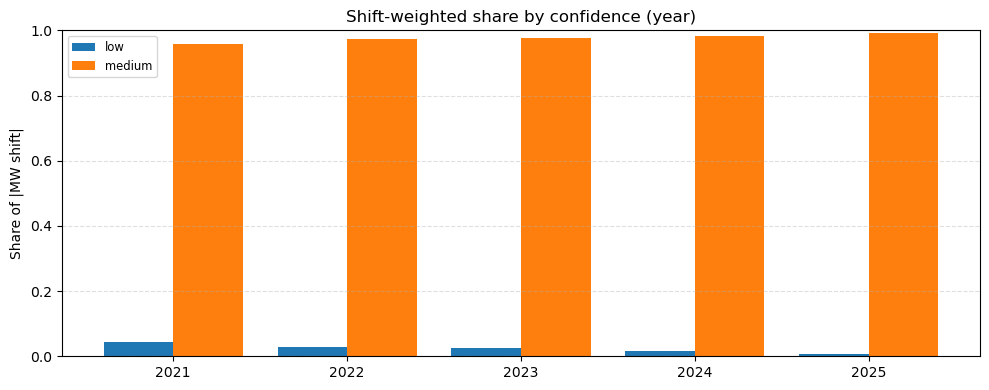

In [164]:
by_year_shift = confidence_weighted_by(
    national_df,
    period="year",
    categories=cats,
    weight_candidates=("National MW Shift","mw_shift"),
    use_abs_weight=True,      # use |shift| so up/down don't cancel
    return_share=True
)
plot_conf_grouped_bars(by_year_shift, group_col="year", categories=cats,
                       title="Shift-weighted share by confidence (year)",
                       y_label="Share of |MW shift|", y_min=0, y_max=1)


<Axes: title={'center': 'Shift-weighted share by confidence (hour)'}, ylabel='Share of |MW shift|'>

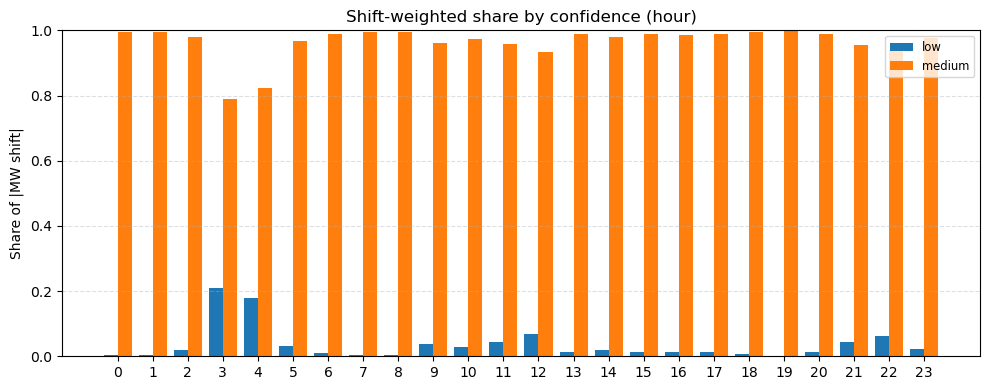

In [165]:
by_hour = confidence_weighted_by(
    national_df,
    period="hour",
    categories=cats,
    weight_candidates=("National MW Shift", "mw_shift"),
    use_abs_weight=True,          # <-- avoid up/down canceling
    return_share=True
)

plot_conf_grouped_bars(
    by_hour,
    group_col="hour",
    categories=cats,
    title="Shift-weighted share by confidence (hour)",
    y_label="Share of |MW shift|",  # <-- correct y-axis label
    y_min=0, y_max=1
)

<Axes: title={'center': 'Total demand by confidence (year)'}, ylabel='kWh'>

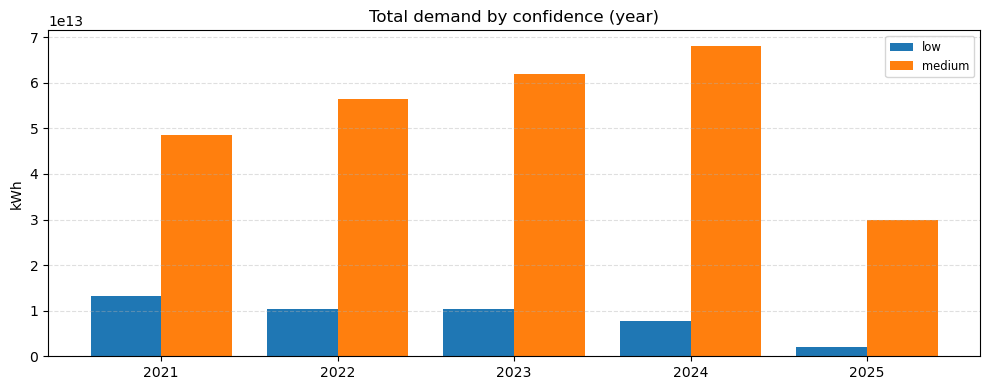

In [166]:
by_year_demand_totals = confidence_weighted_by(
    national_df, period="year", categories=cats,
    weight_candidates=("demand_met_kWh",), return_share=False
)
plot_conf_grouped_bars(by_year_demand_totals, group_col="year", categories=cats,
                       title="Total demand by confidence (year)",
                       y_label="kWh", y_min=0)


#### Calibration

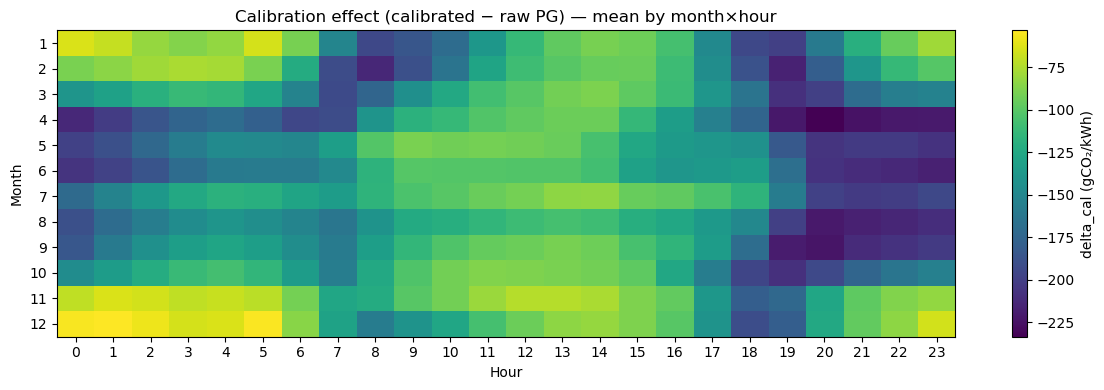

In [167]:
cal_df = calibration_deltas(national_df)
_ = plot_calibration_heatmap_month_hour(cal_df, value_col="delta_cal")

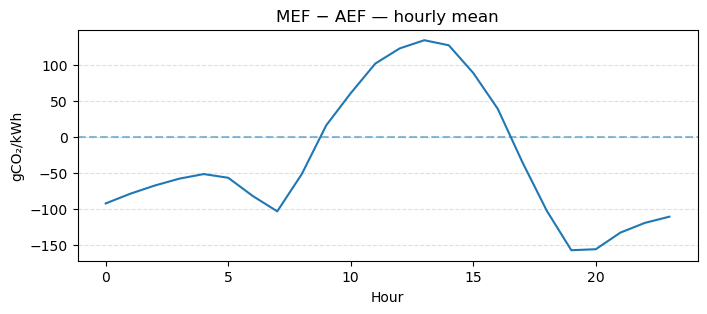

In [168]:
gap = mef_vs_aef_gap(national_df)
plot_gap_hourly_profile(gap, value="delta_mef_aef")

/var/folders/lg/rt7jvg4x71vd57p0zm_718200000gn/T/ipykernel_13433/114483164.py:35: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  tmp = tmp.set_index(pd.to_datetime(tmp[time_col])).sort_index().resample(freq).mean()


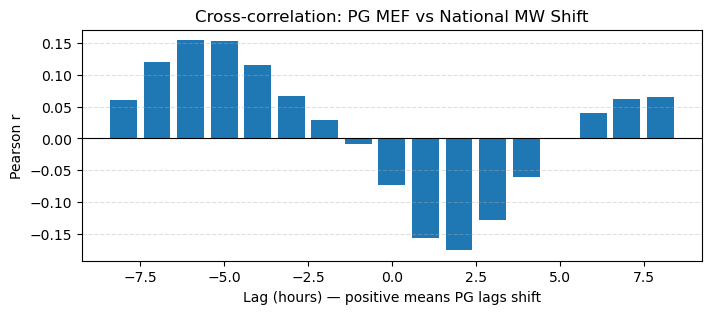

In [169]:
cc = crosscorr_pg_shift(national_df, max_lag=8)
plot_crosscorr(cc)

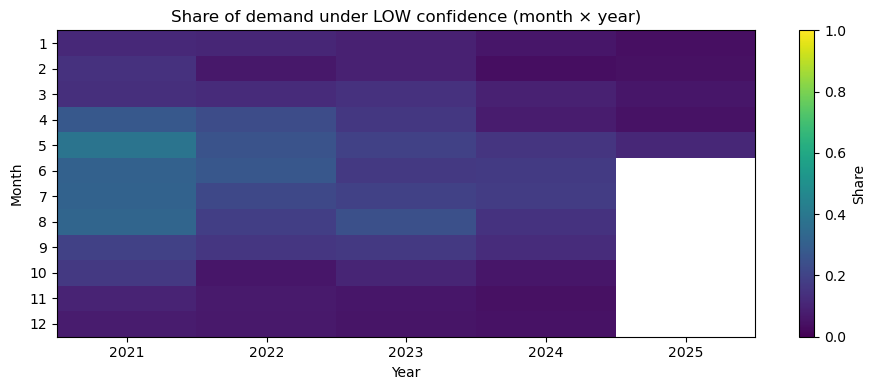

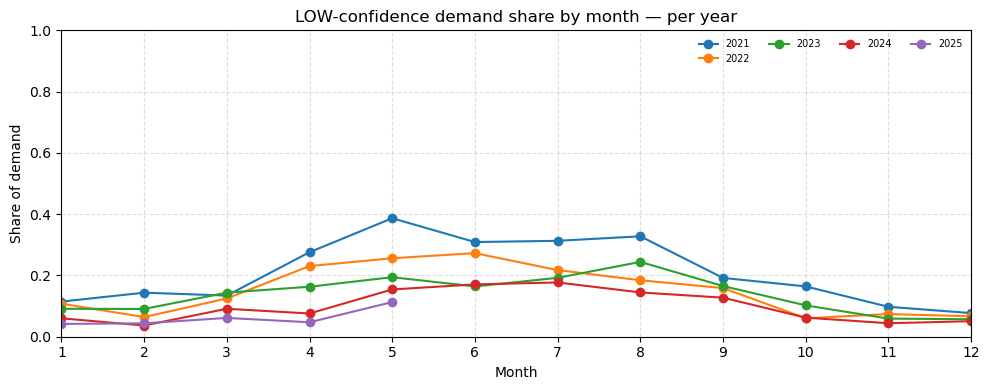

In [170]:
lc = low_conf_demand_share_by_month_year(national_df, low_label="low")
_ = plot_low_conf_share_heatmap(lc)            # heatmap
plot_low_conf_share_lines_by_year(lc)          # lines per year